# Analysis of EPA-Weighted Win Probability Models

## EWMA EPA-Weighted Win Probability Model

Based on the work of [Ben Dominguez](https://opensourcefootball.com/posts/2021-01-21-nfl-game-prediction-using-logistic-regression/), I have created a model that uses exponentially weighted moving averages of EPA to predict the win probability of a team.  The model is trained on data from 1999-2022 and tested on data from 2023.  I have made some updates to the model:

* XGBoost library is used instead of sklearn's LogisticRegression
* Bayesian Optimization is used to tune the hyperparameters of the XGBoost model
* The prediction function is generalized to work for any game in any season

In [1]:
import nfl_data_py as nfl

seasons = list(range(1999, 2024, 1))

pbp_data = nfl.import_pbp_data(seasons, thread_requests=True)
nfl.clean_nfl_data(pbp_data)

pbp_data.head()

Downcasting floats.


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,35.0,1999_01_ARI_PHI,1999091200,PHI,ARI,REG,1,PHI,home,ARI,...,0.0,1.0,0.126818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60.0,1999_01_ARI_PHI,1999091200,PHI,ARI,REG,1,PHI,home,ARI,...,0.0,1.0,-0.561568,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,82.0,1999_01_ARI_PHI,1999091200,PHI,ARI,REG,1,PHI,home,ARI,...,0.0,1.0,-0.641717,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,103.0,1999_01_ARI_PHI,1999091200,PHI,ARI,REG,1,PHI,home,ARI,...,0.0,1.0,-0.723302,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,126.0,1999_01_ARI_PHI,1999091200,PHI,ARI,REG,1,PHI,home,ARI,...,0.0,1.0,0.212661,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Function Definitions

Calibration Data Functions

In [2]:
import numpy as np
import pandas as pd

WP_SELECTED_COLUMNS = [
    'wp_label', 'game_id', 'home_team', 'away_team', 'season', 'half_seconds_remaining',
    'game_seconds_remaining', 'score_differential', 'down', 'ydstogo', 'yardline_100',
    'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'home', 'receive_2h_ko',
    'spread_time', 'diff_time_ratio'
]
WP_DROP_COLUMNS = ['season', 'game_id', 'wp_label', 'home_team', 'away_team']

NEXT_SCORE_HALF_SELECTED_COLUMNS = [
    'game_id', 'Next_Score_Half', 'Drive_Score_Half', 'play_type', 'game_seconds_remaining',
    'half_seconds_remaining', 'yardline_100', 'roof', 'posteam', 'defteam', 'home_team', 'away_team', 'ydstogo',
    'season', 'qtr', 'down', 'week', 'drive', 'ep', 'epa', 'score_differential', 'posteam_timeouts_remaining',
    'defteam_timeouts_remaining', 'desc', 'receiver_player_name', 'pass_location', 'air_yards',
    'yards_after_catch', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit',
    'extra_point_result', 'field_goal_result', 'sp', 'Winner', 'spread_line', 'total_line', 'result'
]

EPA_MODEL_SELECTED_COLUMNS = ['epa_label', 'season', 'half_seconds_remaining', 'yardline_100', 'home', 'retractable',
                              'dome', 'outdoors', 'ydstogo', 'era0', 'era1', 'era2', 'era3', 'era4', 'down1', 'down2',
                              'down3', 'down4', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
                              'Total_W_Scaled']


def drop_rows(df):
    print("Dropping Rows")
    new_df = df.dropna(subset=['down', 'game_seconds_remaining', 'score_differential', 'yardline_100', 'result', 'posteam'])
    new_df = new_df.loc[new_df['qtr'] <= 4]
    new_df = new_df.loc[new_df['result'] != 0]
    return new_df


def add_home_column(df):
    print("Adding Home Column")
    df['home'] = np.where(df['posteam'] == df['home_team'], 1, 0)
    return df


def add_label_column(df):
    print("Adding Label Column")
    df['wp_label'] = df.apply(lambda row: 1 if (row['result'] > 0 and row['posteam'] == row['home_team']) or (row['result'] < 0 and row['posteam'] != row['home_team']) else 0, axis=1)
    return df


def add_receive_2h_ko_column(df):
    print("Adding Receive 2H KO Column")
    new_df = df.groupby('game_id', group_keys=False).apply(
        lambda x: x.assign(
            receive_2h_ko=np.where((x['qtr'] <= 2) & (x['posteam'] == x['defteam'].dropna().iloc[0]), 1, 0)
        )
    )
    return new_df


def add_posteam_spread_elasped_share_columns(df):
    print("Adding Posessing Team Spread and Elapsed Share Columns")
    new_df = df.assign(
        posteam_spread=np.where(df['home'] == 1, df['spread_line'], -1 * df['spread_line']),
        elapsed_share=(3600 - df['game_seconds_remaining']) / 3600,
    )
    return new_df


def add_spread_time_diff_time_ration_columns(df):
    print("Adding Spread Time and Diff Time Ratio Columns")
    new_df = df.assign(
        spread_time=df['posteam_spread'] * np.exp(-4 * df['elapsed_share']),
        diff_time_ratio=df['score_differential'] / (np.exp(-4 * df['elapsed_share']))
    )
    return new_df


def select_relevant_columns(df):
    print("Selecting Relevant Columns")
    return df.filter(items=WP_SELECTED_COLUMNS)


def drop_irrelevant_columns(df):
    print("Dropping Irrelevant Columns")
    return df.drop(columns=WP_DROP_COLUMNS)


def add_features(df):
    new_df = add_home_column(df)
    new_df = add_label_column(new_df)
    new_df = add_receive_2h_ko_column(new_df)
    new_df = add_posteam_spread_elasped_share_columns(new_df)
    new_df = add_spread_time_diff_time_ration_columns(new_df)

    return new_df


def generate_vegas_wp_calibration_data(df):
    print("Preprocessing Data")
    new_df = drop_rows(df)
    new_df = add_features(new_df)
    # new_df = select_relevant_columns(new_df)
    return new_df


def make_model_mutations(pbp):
    pbp['era0'] = np.where(pbp['season'] <= 2001, 1, 0)
    pbp['era1'] = np.where((pbp['season'] > 2001) & (pbp['season'] <= 2005), 1, 0)
    pbp['era2'] = np.where((pbp['season'] > 2005) & (pbp['season'] <= 2013), 1, 0)
    pbp['era3'] = np.where((pbp['season'] > 2013) & (pbp['season'] <= 2017), 1, 0)
    pbp['era4'] = np.where(pbp['season'] > 2017, 1, 0)

    pbp['era'] = np.select([
        pbp['era0'] == 1,
        pbp['era1'] == 1,
        pbp['era2'] == 1,
        (pbp['era3'] == 1) | (pbp['era4'] == 1)
    ], [
        0,
        1,
        2,
        3
    ])

    pbp['era'] = pd.Categorical(pbp['era'])

    pbp['down1'] = np.where(pbp['down'] == 1, 1, 0)
    pbp['down2'] = np.where(pbp['down'] == 2, 1, 0)
    pbp['down3'] = np.where(pbp['down'] == 3, 1, 0)
    pbp['down4'] = np.where(pbp['down'] == 4, 1, 0)

    pbp['home'] = np.where(pbp['posteam'] == pbp['home_team'], 1, 0)

    pbp['model_roof'] = np.where((pbp['roof'].isna()) | (pbp['roof'] == 'open') | (pbp['roof'] == 'closed'),
                                 'retractable', pbp['roof'])
    pbp['model_roof'] = pd.Categorical(pbp['model_roof'])

    pbp['retractable'] = np.where(pbp['model_roof'] == 'retractable', 1, 0)
    pbp['dome'] = np.where(pbp['model_roof'] == 'dome', 1, 0)
    pbp['outdoors'] = np.where(pbp['model_roof'] == 'outdoors', 1, 0)

    return pbp


def find_game_next_score_half(pbp_dataset):
    # Which rows are the scoring plays
    score_plays = pbp_dataset.index[(pbp_dataset['sp'] == 1) & (pbp_dataset['play_type'] != "no_play")].tolist()

    def find_next_score(play_i, score_plays_i, pbp_df):
        # game_id = pbp_df.iloc[0]['game_id']
        # df_len = len(pbp_df)
        # print(f"{game_id}: Play {play_i} of {len(pbp_df)} Status: Beginning")
        # Find the next score index for the current play
        next_scores = [i for i in score_plays_i if i >= play_i]
        # print(f"{game_id}: Play {play_i} of {df_len}: Next Scores: {next_scores} Status: Phase 1")
        next_score_i = next_scores[0] if next_scores else None
        # print(f"{game_id}: Play {play_i} of {df_len}: Next Score Index: {next_score_i} Status: Phase 2")
        # next_score_i_qtr = pbp_df.loc[next_score_i, 'qtr'] if next_score_i else None
        # print(f"{game_id}: Play {play_i} of {df_len}: Next Score Qtr: {next_score_i_qtr} Status: Phase 3")

        if next_score_i is None or \
                (pbp_df.loc[play_i, 'qtr'] in [1, 2] and pbp_df.loc[next_score_i, 'qtr'] in [3, 4, 5]) or \
                (pbp_df.loc[play_i, 'qtr'] in [3, 4] and pbp_df.loc[next_score_i, 'qtr'] == 5):
            score_type = "No_Score"
            # print(f"{game_id}: Play {play_i} of {df_len}: Score Type: {score_type}, Status: Phase 4")
            score_drive = pbp_df.loc[play_i, 'drive']
            # print(f"{game_id}: Play {play_i} of {df_len}: Score Drive: {score_drive} Status: Phase 5")
        else:
            score_drive = pbp_df.loc[next_score_i, 'drive']
            # print(f"{game_id}: Play {play_i} of {df_len}: Score Drive: {score_drive} Status: Phase 6")

            if pbp_df.loc[next_score_i, 'touchdown'] == 1 and (
                    pbp_df.loc[next_score_i, 'td_team'] != pbp_df.loc[next_score_i, 'posteam']):
                if pbp_df.loc[play_i, 'posteam'] == pbp_df.loc[next_score_i, 'posteam']:
                    score_type = "Opp_Touchdown"
                else:
                    score_type = "Touchdown"
            elif pbp_df.loc[next_score_i, 'field_goal_result'] == "made":
                if pbp_df.loc[play_i, 'posteam'] == pbp_df.loc[next_score_i, 'posteam']:
                    score_type = "Field_Goal"
                else:
                    score_type = "Opp_Field_Goal"
            elif pbp_df.loc[next_score_i, 'touchdown'] == 1:
                if pbp_df.loc[play_i, 'posteam'] == pbp_df.loc[next_score_i, 'posteam']:
                    score_type = "Touchdown"
                else:
                    score_type = "Opp_Touchdown"
            elif pbp_df.loc[next_score_i, 'safety'] == 1:
                if pbp_df.loc[play_i, 'posteam'] == pbp_df.loc[next_score_i, 'posteam']:
                    score_type = "Opp_Safety"
                else:
                    score_type = "Safety"
            elif pbp_df.loc[next_score_i, 'extra_point_result'] == "good":
                if pbp_df.loc[play_i, 'posteam'] == pbp_df.loc[next_score_i, 'posteam']:
                    score_type = "Extra_Point"
                else:
                    score_type = "Opp_Extra_Point"
            elif pbp_df.loc[next_score_i, 'two_point_conv_result'] == "success":
                if pbp_df.loc[play_i, 'posteam'] == pbp_df.loc[next_score_i, 'posteam']:
                    score_type = "Two_Point_Conversion"
                else:
                    score_type = "Opp_Two_Point_Conversion"
            elif pbp_df.loc[next_score_i, 'defensive_two_point_conv'] == 1:
                if pbp_df.loc[play_i, 'posteam'] == pbp_df.loc[next_score_i, 'posteam']:
                    score_type = "Opp_Defensive_Two_Point"
                else:
                    score_type = "Defensive_Two_Point"
            else:
                score_type = None
        # print(f"{pbp_df.iloc[0]['game_id']}: Play {play_i} of {len(pbp_df)}: Score Type: {score_type} Status: Completed")
        return pd.DataFrame({'Next_Score_Half': [score_type], 'Drive_Score_Half': [score_drive]}, index=[play_i])

    # Applying the helper function to each row of the dataset
    next_score_data = [find_next_score(i, score_plays, pbp_dataset) for i in pbp_dataset.index]
    return pd.concat(next_score_data)


def get_regular_season_games(df):
    return df.loc[df['season_type'] == 'REG']


def get_unique_game_ids(df):
    return df['game_id'].unique()


def determine_winner(df):
    df['Winner'] = np.where(df['home_score'] > df['away_score'],
                            df['home_team'],
                            np.where(df['home_score'] < df['away_score'], df['away_team'], "TIE"))

    return df


def generate_game_dfs_by_game_id(df):
    grouped = df.groupby('game_id')
    games = [game for game_id, game in grouped]

    return games


def update_label_mapping(df):
    label_mapping = {
        "Touchdown": 0,
        "Opp_Touchdown": 1,
        "Field_Goal": 2,
        "Opp_Field_Goal": 3,
        "Safety": 4,
        "Opp_Safety": 5,
        "No_Score": 6
    }
    df['epa_label'] = df['Next_Score_Half'].map(label_mapping)
    df['epa_label'] = pd.factorize(df['epa_label'])[0]
    return df


def add_nflscrapr_weights(df):
    df['Drive_Score_Dist'] = df['Drive_Score_Half'] - df['drive']
    df['Drive_Score_Dist_W'] = (df['Drive_Score_Dist'].max() - df['Drive_Score_Dist']) / (
            df['Drive_Score_Dist'].max() - df['Drive_Score_Dist'].min())
    df['ScoreDiff_W'] = (df['score_differential'].dropna().abs().max() - df[
        'score_differential'].dropna().abs()) / (
                                df['score_differential'].dropna().abs().max() - df[
                            'score_differential'].dropna().abs().min())
    df['Total_W'] = df['Drive_Score_Dist_W'] + df['ScoreDiff_W']
    df['Total_W_Scaled'] = (df['Total_W'] - df['Total_W'].dropna().min()) / (
            df['Total_W'].dropna().max() - df['Total_W'].dropna().min())
    df['Total_W_Scaled'] = df['Total_W_Scaled'].fillna(0)
    df['epa_label'] = df['epa_label'].astype('int64') + 1

    return df


def filter_epa_model_selected_columns(df):
    cal_data = df.dropna(subset=['defteam_timeouts_remaining', 'posteam_timeouts_remaining', 'yardline_100'])
    cal_data = cal_data[EPA_MODEL_SELECTED_COLUMNS]
    return cal_data


def process_game_epa(df):
    reg_pbp_data = df.copy()
    reg_pbp_data = reg_pbp_data.loc[reg_pbp_data['season_type'] == 'REG']
    reg_pbp_data['Winner'] = np.where(reg_pbp_data['home_score'] > reg_pbp_data['away_score'],
                                      reg_pbp_data['home_team'],
                                      np.where(reg_pbp_data['home_score'] < reg_pbp_data['away_score'],
                                               reg_pbp_data['away_team'], "TIE"))
    unique_game_ids = reg_pbp_data['game_id'].unique()
    pbp_next_score_half = pd.concat(
        [find_game_next_score_half(reg_pbp_data[reg_pbp_data['game_id'] == game_id]) for game_id in unique_game_ids])
    # Bind to original DataFrame
    reg_pbp_data = pd.concat([reg_pbp_data, pbp_next_score_half], axis=1)

    # Apply filters for estimating the models
    filtered_pbp_data = reg_pbp_data[
        (reg_pbp_data['Next_Score_Half'].isin(["Opp_Field_Goal", "Opp_Safety", "Opp_Touchdown",
                                               "Field_Goal", "No_Score", "Safety", "Touchdown"])) &
        (reg_pbp_data['play_type'].isin(["field_goal", "no_play", "pass", "punt", "run", "qb_spike"])) &
        (reg_pbp_data['two_point_conv_result'].isna()) &
        (reg_pbp_data['extra_point_result'].isna()) &
        (reg_pbp_data['down'].notna()) &
        (reg_pbp_data['game_seconds_remaining'].notna())
        ]

    # Selecting specific columns to keep file size manageable
    selected_columns = [
        'game_id', 'Next_Score_Half', 'Drive_Score_Half', 'play_type', 'game_seconds_remaining',
        'half_seconds_remaining', 'yardline_100', 'roof', 'posteam', 'defteam', 'home_team', 'ydstogo',
        'season', 'qtr', 'down', 'week', 'drive', 'ep', 'epa', 'score_differential', 'posteam_timeouts_remaining',
        'defteam_timeouts_remaining', 'desc', 'receiver_player_name', 'pass_location', 'air_yards',
        'yards_after_catch', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit',
        'extra_point_result', 'field_goal_result', 'sp', 'Winner', 'spread_line', 'total_line', 'result'
    ]
    filtered_pbp_data = filtered_pbp_data[selected_columns]
    cal_data_df = make_model_mutations(filtered_pbp_data)

    # Define label mapping
    label_mapping = {
        "Touchdown": 0,
        "Opp_Touchdown": 1,
        "Field_Goal": 2,
        "Opp_Field_Goal": 3,
        "Safety": 4,
        "Opp_Safety": 5,
        "No_Score": 6
    }

    # Apply label mapping
    cal_data_df['epa_label'] = cal_data_df['Next_Score_Half'].map(label_mapping)
    cal_data_df['epa_label'] = pd.factorize(cal_data_df['epa_label'])[0]

    # Use nflscrapR weights
    cal_data_df['Drive_Score_Dist'] = cal_data_df['Drive_Score_Half'] - cal_data_df['drive']
    cal_data_df['Drive_Score_Dist_W'] = (cal_data_df['Drive_Score_Dist'].max() - cal_data_df['Drive_Score_Dist']) / (
            cal_data_df['Drive_Score_Dist'].max() - cal_data_df['Drive_Score_Dist'].min())
    cal_data_df['ScoreDiff_W'] = (cal_data_df['score_differential'].dropna().abs().max() - cal_data_df[
        'score_differential'].dropna().abs()) / (
                                         cal_data_df['score_differential'].dropna().abs().max() - cal_data_df[
                                     'score_differential'].dropna().abs().min())
    cal_data_df['Total_W'] = cal_data_df['Drive_Score_Dist_W'] + cal_data_df['ScoreDiff_W']
    cal_data_df['Total_W_Scaled'] = (cal_data_df['Total_W'] - cal_data_df['Total_W'].dropna().min()) / (
            cal_data_df['Total_W'].dropna().max() - cal_data_df['Total_W'].dropna().min())
    cal_data_df['Total_W_Scaled'] = cal_data_df['Total_W_Scaled'].fillna(0)

    return cal_data_df


In [3]:
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb
from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import log_loss, accuracy_score
import seaborn as sns
import itertools


WP_MODEL_FEATURES = [
    "home_team",
    "away_team",
    "posteam",
    "defteam",
    "yardline_100",
    "half_seconds_remaining",
    "game_seconds_remaining",
    "game_half",
    "down",
    "ydstogo",
    "home_timeouts_remaining",
    "away_timeouts_remaining",
    "score_differential_post"
]


def get_epa(df, mode, play_type):
    return df.loc[df[play_type] == 1, :].groupby([mode, 'season', 'week'], as_index=False)['epa'].mean()


def plot_epa(df, league_df, team, mode):
    tm = df.loc[df['team'] == team, :].assign(
        season_week=lambda x: 'w' + x.week.astype(str) + ' (' + x.season.astype(str) + ')'
    ).set_index('season_week')
    league_avg = league_df.assign(
        season_week=lambda x: 'w' + x.week.astype(str) + ' (' + x.season.astype(str) + ')'
    ).set_index('season_week')
    fig, ax = plt.subplots()
    loc = plticker.MultipleLocator(base=16)
    ax.xaxis.set_major_locator(loc)
    ax.tick_params(axis='x', rotation=75)
    ax.plot(tm[f"epa_shifted_{mode}_offense"], lw=1, alpha=0.5)
    ax.plot(tm[f"ewma_dynamic_window_{mode}_offense"], lw=2)
    ax.plot(tm[f"ewma_{mode}_offense"], lw=2);
    ax.plot(league_df[f"epa_shifted_league_{mode}_offense"], lw=2, alpha=0.5)
    ax.plot(league_df[f"ewma_dynamic_window_league_{mode}_offense"], lw=2)
    ax.plot(league_df[f"ewma_league_{mode}_offense"], lw=2);
    plt.axhline(y=0, color='red', lw=1.5, alpha=0.5)
    ax.legend([f"{mode} EPA", 'EWMA on EPA with dynamic window', 'Static 10 EWMA on EPA', f"League {mode} EPA", f"League EWMA on EPA with dynamic window", f"League Static 10 EWMA on EPA"])
    ax.set_title(f'{team} {mode} EPA per play')
    return plt


def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i + 1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]

    return pd.Series(values, index=x.index)


def lag_epa_one_period(df, mode):
    return df.groupby(mode)['epa'].shift()


def calculate_ewma(df, mode):
    return df.groupby(mode)['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())


def calculate_dynamic_window_ewma(df, mode):
    return df.groupby(mode).apply(dynamic_window_ewma).values


def merge_epa_data(rush_df, pass_df, mode):
    return rush_df.merge(pass_df, on=[mode, 'season', 'week'], suffixes=('_rushing', '_passing')).rename(
        columns={mode: 'team'})


def get_schedule(dataset_df, epa_df):
    schedule = dataset_df[
        ['season', 'week', 'home_team', 'away_team', 'home_score',
         'away_score']].drop_duplicates().reset_index(
        drop=True).assign(
        home_team_win=lambda x: (x.home_score > x.away_score).astype(int))
    return schedule.merge(epa_df.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week']).merge(
        epa_df.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], suffixes=('_home', '_away'))


def get_most_important_features(df):
    features = [column for column in df.columns if 'ewma' in column and 'dynamic' in column]
    return features


def get_data_with_features(df, season, features, target):
    df = df.dropna()
    x = df.loc[df['season'] != season, features].values
    y = df.loc[df['season'] != season, target].values
    clf = LogisticRegression()
    return x, y, clf


def get_data_with_features_xgb_regressor(X, y, params):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    clf = xgb.XGBClassifier(**params)

    return X_train, X_test, y_train, y_test, clf


def get_accuracy_scores(x, y, clf, cv, scoring):
    accuracy_scores = cross_val_score(clf, x, y, cv=cv)
    log_losses = cross_val_score(clf, x, y, cv=cv, scoring=scoring)
    model_accuracy = np.mean(accuracy_scores)
    neg_log_loss = np.mean(log_losses)

    return accuracy_scores, model_accuracy, log_losses, neg_log_loss


def plot_most_important_features(features, clf):
    fig, ax = plt.subplots()
    feature_names = ['_'.join(feature_name.split('_')[3:]) for feature_name in features]
    coef_ = clf.coef_[0]
    features_coef_sorted = sorted(zip(feature_names, coef_), key=lambda x: x[-1], reverse=True)
    features_sorted = [feature for feature, _ in features_coef_sorted]
    coef_sorted = [coef for _, coef in features_coef_sorted]
    ax.set_title('Feature Importance')
    ax.barh(features_sorted, coef_sorted)
    plt.show()
    return plt


def create_stratified_k_folds(df, num_splits, split_year, features):
    folds = StratifiedKFold(n_splits=num_splits)
    training_labels = df.loc[df["season"] < split_year, 'home_team_win']
    training_data = df.loc[df["season"] < split_year, features]
    test_data = df.loc[df["season"] >= split_year, features]

    train_data = xgb.DMatrix(data=training_data, label=training_labels, nthread=-1)
    return folds, train_data, test_data

def create_sk_stratifiedkfolds(X, y, num_splits):
    folds = StratifiedKFold(n_splits=num_splits)
    for train_index, test_index in folds.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    return X_train, X_test, y_train, y_test


def create_group_k_folds(X, y, num_splits, groups):
    folds = GroupKFold(n_splits=num_splits)
    for train_index, test_index in folds.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    return X_train, X_test, y_train, y_test


def scoring_function(colsample_bytree, eta, max_depth, min_child_weight, subsample, gamma):
    params = {
        'booster': 'gbtree',
        'device': 'cuda',
        'colsample_bytree': colsample_bytree,
        'eta': eta,
        'max_depth': int(max_depth),
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'gamma': gamma,
        'sampling_method': 'gradient_based',
        'objective': 'binary:logistic',
        'tree_method': 'approx',
        'eval_metric': 'logloss'
    }

    xgbcv = xgb.cv(
        params=params,
        dtrain=train_data,
        stratified=True,
        folds=folds,
        num_boost_round=num_rounds,
        early_stopping_rounds=50
    )
    return max((xgbcv['test-logloss-mean'] * -1))


def begin_bayesian_optimization(init_points_factor=1, n_iter_factor=10):
    acquisition_function = UtilityFunction(kind="ucb", kappa=10)
    bayesian_opt = BayesianOptimization(f=scoring_function, pbounds=bounds)
    bayesian_opt.maximize(init_points=len(bounds) * init_points_factor,
                          n_iter=len(bounds) * n_iter_factor, acquisition_function=acquisition_function)
    return bayesian_opt


def get_scores(matrix, schedule, model):
    preds = pd.DataFrame(model.predict(matrix),
                         columns=['wp'])
    schedule = schedule[["season", "week", "home_team", "away_team", "home_score", "away_score", "home_team_win"]]
    df_preds = pd.concat([preds, schedule], axis=1)
    logloss_score = log_loss(df_preds['home_team_win'], df_preds['wp'])
    accuracy = accuracy_score(df_preds['home_team_win'], df_preds['wp'] > 0.5)
    return logloss_score, accuracy, df_preds


def plot_calibration_score(df):
    df['bin_pred_prob'] = np.round(df['wp'] / 0.05) * 0.05
    calibration_data = df.groupby('bin_pred_prob').agg(
        n_plays=('home_team_win', 'count'),
        n_wins=('home_team_win', lambda x: np.sum(x == 1))
    ).reset_index()
    calibration_data['bin_actual_prob'] = calibration_data['n_wins'] / calibration_data['n_plays']
    ann_text = pd.DataFrame({
        'x': [0.25, 0.75],
        'y': [0.75, 0.25],
        'lab': ["More times\nthan expected", "Fewer times\nthan expected"]
    })
    plt.figure(figsize=(10, 6))

    sns.scatterplot(data=calibration_data, x='bin_pred_prob', y='bin_actual_prob', size='n_plays')
    sns.regplot(data=calibration_data, x='bin_pred_prob', y='bin_actual_prob', scatter=False, lowess=True)
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("Estimated win probability")
    plt.ylabel("Observed win probability")
    plt.title("Win Prob Calibration Plot")
    plt.text(0.25, 0.75, "More times\nthan expected", fontsize=10)
    plt.text(0.75, 0.25, "Fewer times\nthan expected", fontsize=10)
    plt.legend(['Perfect Calibration', 'Plays'])
    plt.tight_layout()
    plt.show()
    
    
def ewma(data, window):
    """
    Calculate the most recent value for EWMA given an array of data and a window size
    """
    alpha = 2 / (window + 1.0)
    alpha_rev = 1 - alpha
    scale = 1 / alpha_rev
    n = data.shape[0]
    r = np.arange(n)
    scale_arr = scale ** r
    offset = data[0] * alpha_rev ** (r + 1)
    pw0 = alpha * alpha_rev ** (n - 1)
    mult = data * pw0 * scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums * scale_arr[::-1]
    return out[-1]


def get_pregame_predictions(df, season, model, bet_lines_df):
    game_df = df.loc[(df['season'] == season)]
    pregame_data = pd.DataFrame()
    for i, x in bet_lines_df.iterrows():
        home = x['home_team']
        away = x['away_team']
        offense = game_df.loc[(game_df['posteam'] == home) | (game_df['posteam'] == away)]
        defense = game_df.loc[(game_df['defteam'] == home) | (game_df['defteam'] == away)]
        rushing_offense = offense.loc[offense['rush_attempt'] == 1].groupby(['posteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'posteam': 'team'})
        passing_offense = offense.loc[offense['pass_attempt'] == 1].groupby(['posteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'posteam': 'team'})
        rushing_defense = defense.loc[defense['rush_attempt'] == 1].groupby(['defteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'defteam': 'team'})
        passing_defense = defense.loc[defense['pass_attempt'] == 1].groupby(['defteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'defteam': 'team'})
        pregame = np.zeros(8)

        for i, (tm, stat_df) in enumerate(
                itertools.product([home, away], [rushing_offense, passing_offense, rushing_defense, passing_defense])):
            ewma_value = ewma(stat_df.loc[stat_df['team'] == tm]['epa'].values, 20)
            pregame[i] = ewma_value

        pregame_df = pd.DataFrame()
        for x, y in zip(features, pregame):
            pregame_df[x] = [y]
        pregame_data = pd.concat([pregame_data, pregame_df], ignore_index=True)
    pregame_matrix = xgb.DMatrix(data=pregame_data, nthread=-1)
    bet_lines_df['home_win_prob'] = pd.DataFrame(model.predict(pregame_matrix),
                                                 columns=['home_win_prob'])
    bet_lines_df["final_score_diff"] = bet_lines_df["home_score"] - bet_lines_df["away_score"]
    bet_lines_df["recommended_bet"] = np.where(
        (bet_lines_df['home_win_prob'] > 0.71) & (
                bet_lines_df['home_spread_line'] < 0), bet_lines_df["home_team"], bet_lines_df["away_team"])
    bet_lines_df["final_spread"] = bet_lines_df["home_spread_line"] + bet_lines_df["final_score_diff"]
    bet_lines_df["correct_prediction"] = np.where(
        (bet_lines_df["recommended_bet"] == bet_lines_df["home_team"]) & (bet_lines_df["final_spread"] >= 0) | (
                bet_lines_df["recommended_bet"] == bet_lines_df["away_team"]) & (bet_lines_df["final_spread"] < 0), 1,
        0)
    return bet_lines_df


def predict_season(df, season, clf, features):
    season_df = df.loc[(df['season'] == season)].assign(
        predicted_winner = lambda x: clf.predict(x[features]),
        home_team_win_probability = lambda x: clf.predict_proba(x[features])[:,1])[
        ['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]
    season_df['actual_winner'] = season_df.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
    season_df['predicted_winner'] = season_df.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
    season_df['win_probability'] = season_df.apply(
        lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
    season_df['correct_prediction'] = (season_df['predicted_winner'] == season_df['actual_winner']).astype(int)
    season_df = season_df.drop(columns=['home_team_win_probability', 'home_team_win'])
    return season_df.sort_values(by='win_probability', ascending=False).reset_index(drop=True)


def get_correct_predictions(df):
    correct = df.loc[df['correct_prediction'] == 1].groupby('week')['correct_prediction'].sum()
    num_games = df.groupby('week')['correct_prediction'].size()
    return correct / num_games


def get_season_prediction_outcomes(df, correct_predictions):
    return df.loc[df['week'] == correct_predictions.idxmax()].sort_values(by='win_probability', ascending=False)

### EPA Preprocessing

<module 'matplotlib.pyplot' from '/home/dev/.virtualenvs/nfl-data-models/lib/python3.10/site-packages/matplotlib/pyplot.py'>

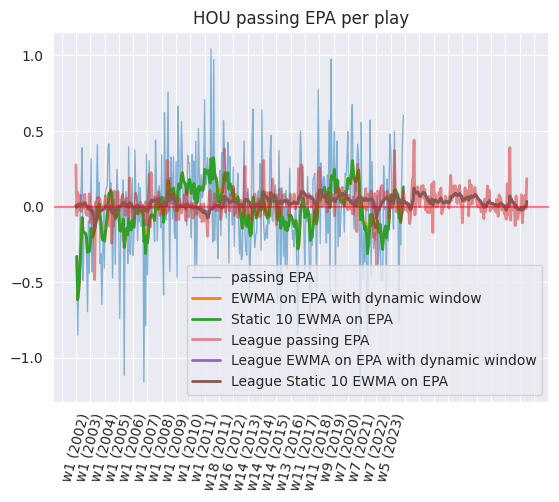

In [4]:
# seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = get_epa(pbp_data, 'posteam', 'rush_attempt')
rushing_defense_epa = get_epa(pbp_data, 'defteam', 'rush_attempt')
passing_offense_epa = get_epa(pbp_data, 'posteam', 'pass_attempt')
passing_defense_epa = get_epa(pbp_data, 'defteam', 'pass_attempt')

# get league average EPA for each play type
league_rushing_offense_epa = rushing_offense_epa.groupby(['season', 'week'], as_index=False)['epa'].mean()
league_rushing_defense_epa = rushing_defense_epa.groupby(['season', 'week'], as_index=False)['epa'].mean()
league_passing_offense_epa = passing_offense_epa.groupby(['season', 'week'], as_index=False)['epa'].mean()
league_passing_defense_epa = passing_defense_epa.groupby(['season', 'week'], as_index=False)['epa'].mean()


# lag EPA one period back
rushing_offense_epa['epa_shifted'] = lag_epa_one_period(rushing_offense_epa, 'posteam')
rushing_defense_epa['epa_shifted'] = lag_epa_one_period(rushing_defense_epa, 'defteam')
passing_offense_epa['epa_shifted'] = lag_epa_one_period(passing_offense_epa, 'posteam')
passing_defense_epa['epa_shifted'] = lag_epa_one_period(passing_defense_epa, 'defteam')

league_rushing_offense_epa['epa_shifted'] = league_rushing_offense_epa['epa_shifted'] = league_rushing_offense_epa['epa'].shift()
league_rushing_defense_epa['epa_shifted'] = league_rushing_defense_epa['epa_shifted'] = league_rushing_defense_epa['epa'].shift()
league_passing_offense_epa['epa_shifted'] = league_passing_offense_epa['epa_shifted'] = league_passing_offense_epa['epa'].shift()
league_passing_defense_epa['epa_shifted'] = league_passing_defense_epa['epa_shifted'] = league_passing_defense_epa['epa'].shift()

# In each case, calculate EWMA with a static window and dynamic window and assign it as a column
rushing_offense_epa['ewma'] = calculate_ewma(rushing_offense_epa, 'posteam')
rushing_offense_epa['ewma_dynamic_window'] = calculate_dynamic_window_ewma(rushing_offense_epa, 'posteam')

rushing_defense_epa['ewma'] = calculate_ewma(rushing_defense_epa, 'defteam')
rushing_defense_epa['ewma_dynamic_window'] = calculate_dynamic_window_ewma(rushing_defense_epa, 'defteam')

passing_offense_epa['ewma'] = calculate_ewma(passing_offense_epa, 'posteam')
passing_offense_epa['ewma_dynamic_window'] = calculate_dynamic_window_ewma(passing_offense_epa, 'posteam')

passing_defense_epa['ewma'] = calculate_ewma(passing_defense_epa, 'defteam')
passing_defense_epa['ewma_dynamic_window'] = calculate_dynamic_window_ewma(passing_defense_epa, 'defteam')

league_rushing_offense_epa['ewma'] = league_rushing_offense_epa['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
league_rushing_offense_epa['ewma_dynamic_window'] = dynamic_window_ewma(league_rushing_offense_epa).values

league_rushing_defense_epa['ewma'] = league_rushing_defense_epa['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
league_rushing_defense_epa['ewma_dynamic_window'] = dynamic_window_ewma(league_rushing_defense_epa).values

league_passing_offense_epa['ewma'] = league_passing_offense_epa['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
league_passing_offense_epa['ewma_dynamic_window'] = dynamic_window_ewma(league_passing_offense_epa).values

league_passing_defense_epa['ewma'] = league_passing_defense_epa['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
league_passing_defense_epa['ewma_dynamic_window'] = dynamic_window_ewma(league_passing_defense_epa).values

# Merge all the data together
offense_epa = merge_epa_data(rushing_offense_epa, passing_offense_epa, 'posteam')
defense_epa = merge_epa_data(rushing_defense_epa, passing_defense_epa, 'defteam')

league_offense_epa = league_rushing_offense_epa.merge(league_passing_offense_epa, on=['season', 'week'], suffixes=('_league_rushing', '_league_passing'))
league_defense_epa = league_rushing_defense_epa.merge(league_passing_defense_epa, on=['season', 'week'], suffixes=('_league_rushing', '_league_passing'))

epa = offense_epa.merge(defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

league_epa = league_offense_epa.merge(league_defense_epa, on=['season', 'week'], suffixes=('_offense', '_defense'))
league_epa['league_average_passing_epa'] = league_epa[['ewma_dynamic_window_league_passing_offense', 'ewma_dynamic_window_league_passing_defense']].sum(axis=1)
league_epa['league_average_rushing_epa'] = league_epa[['ewma_dynamic_window_league_rushing_offense', 'ewma_dynamic_window_league_rushing_defense']].sum(axis=1)

# remove the first season of data
epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]
league_epa = league_epa.loc[league_epa['season'] != league_epa['season'].unique()[0], :]

epa = epa.reset_index(drop=True)
league_epa = league_epa.reset_index(drop=True)

plot_epa(epa, league_epa, 'HOU', 'passing')

### EWMA Model - Sklearn Logistic Regression

In [5]:
schedule = get_schedule(pbp_data, epa)

schedule_with_league_stats = pd.merge(schedule, league_epa, on=['season', 'week'], suffixes=('_schedule', '_league'))

schedule_with_league_stats['home_off_passing_adjustment_factor'] = schedule_with_league_stats['league_average_passing_epa'] - schedule_with_league_stats['ewma_dynamic_window_passing_defense_away']
schedule_with_league_stats['home_def_passing_adjustment_factor'] = schedule_with_league_stats['league_average_passing_epa'] - schedule_with_league_stats['ewma_dynamic_window_passing_offense_away']

schedule_with_league_stats['home_off_rushing_adjustment_factor'] = schedule_with_league_stats['league_average_rushing_epa'] - schedule_with_league_stats['ewma_dynamic_window_rushing_defense_away']
schedule_with_league_stats['home_def_rushing_adjustment_factor'] = schedule_with_league_stats['league_average_rushing_epa'] - schedule_with_league_stats['ewma_dynamic_window_rushing_offense_away']

schedule_with_league_stats['away_off_passing_adjustment_factor'] = schedule_with_league_stats['league_average_passing_epa'] - schedule_with_league_stats['ewma_dynamic_window_passing_defense_home']
schedule_with_league_stats['away_def_passing_adjustment_factor'] = schedule_with_league_stats['league_average_passing_epa'] - schedule_with_league_stats['ewma_dynamic_window_passing_offense_home']

schedule_with_league_stats['away_off_rushing_adjustment_factor'] = schedule_with_league_stats['league_average_rushing_epa'] - schedule_with_league_stats['ewma_dynamic_window_rushing_defense_home']
schedule_with_league_stats['away_def_rushing_adjustment_factor'] = schedule_with_league_stats['league_average_rushing_epa'] - schedule_with_league_stats['ewma_dynamic_window_rushing_offense_home']

schedule_with_league_stats['home_adjusted_off_passing_epa'] = schedule_with_league_stats['ewma_dynamic_window_passing_offense_home'] + schedule_with_league_stats['home_off_passing_adjustment_factor']
schedule_with_league_stats['home_adjusted_def_passing_epa'] = schedule_with_league_stats['ewma_dynamic_window_passing_defense_home'] + schedule_with_league_stats['home_def_passing_adjustment_factor']

schedule_with_league_stats['home_adjusted_off_rushing_epa'] = schedule_with_league_stats['ewma_dynamic_window_rushing_offense_home'] + schedule_with_league_stats['home_off_rushing_adjustment_factor']
schedule_with_league_stats['home_adjusted_def_rushing_epa'] = schedule_with_league_stats['ewma_dynamic_window_rushing_defense_home'] + schedule_with_league_stats['home_def_rushing_adjustment_factor']

schedule_with_league_stats['away_adjusted_off_passing_epa'] = schedule_with_league_stats['ewma_dynamic_window_passing_offense_away'] + schedule_with_league_stats['away_off_passing_adjustment_factor']
schedule_with_league_stats['away_adjusted_def_passing_epa'] = schedule_with_league_stats['ewma_dynamic_window_passing_defense_away'] + schedule_with_league_stats['away_def_passing_adjustment_factor']

schedule_with_league_stats['away_adjusted_off_rushing_epa'] = schedule_with_league_stats['ewma_dynamic_window_rushing_offense_away'] + schedule_with_league_stats['away_off_rushing_adjustment_factor']
schedule_with_league_stats['away_adjusted_def_rushing_epa'] = schedule_with_league_stats['ewma_dynamic_window_rushing_defense_away'] + schedule_with_league_stats['away_def_rushing_adjustment_factor']

sched_df = nfl.import_schedules(seasons)
sched_df.loc[sched_df['season'] != sched_df['season'].unique()[0], :]
sched_df = sched_df.reset_index(drop=True)

train_schedules = sched_df.loc[sched_df['result'].notna()]

schedule_with_league_stats['home_rest'] = train_schedules['home_rest']
schedule_with_league_stats['away_rest'] = train_schedules['away_rest']

features = ['ewma_dynamic_window_rushing_offense_home',
            'ewma_dynamic_window_passing_offense_home',
            'ewma_dynamic_window_rushing_defense_home',
            'ewma_dynamic_window_passing_defense_home',
            'ewma_dynamic_window_rushing_offense_away',
            'ewma_dynamic_window_passing_offense_away',
            'ewma_dynamic_window_rushing_defense_away',
            'ewma_dynamic_window_passing_defense_away',
            'home_adjusted_off_passing_epa',
            'home_adjusted_def_passing_epa',
            'home_adjusted_off_rushing_epa',
            'home_adjusted_def_rushing_epa',
            'away_adjusted_off_passing_epa',
            'away_adjusted_def_passing_epa',
            'away_adjusted_off_rushing_epa',
            'away_adjusted_def_rushing_epa',
            'home_rest',
            'away_rest']
# features = get_most_important_features(schedule_with_league_stats)
test_data_season = 2023
target = 'home_team_win'

# X, y, clf = get_data_with_features(schedule_with_league_stats, test_data_season, features, target)
# clf.fit(X, y)

In [6]:
# cross_validation_subset = 1000
# cross_validation_scoring_method = 'neg_log_loss'
# accuracy_scores, model_accuracy, log_losses, neg_log_loss = get_accuracy_scores(X, y, clf, cross_validation_subset,
#                                                                                 cross_validation_scoring_method)
# print(f'Model Accuracy: {model_accuracy}')
# print(f'Negative Log Losses: {neg_log_loss}')

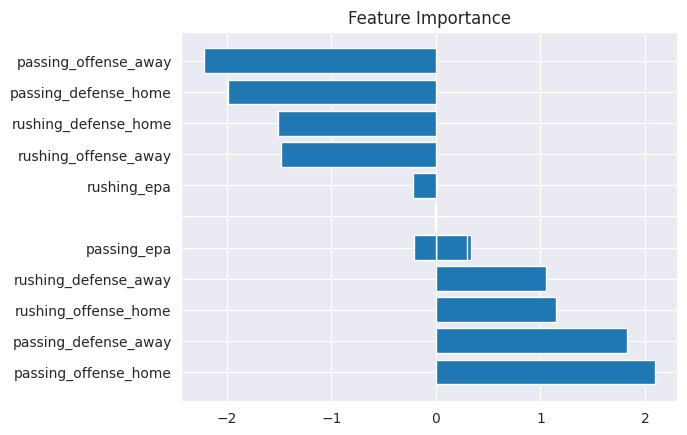

<module 'matplotlib.pyplot' from '/home/dev/.virtualenvs/nfl-data-models/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [9]:
plot_most_important_features(features, clf)

In [7]:
# test_data = schedule_with_league_stats.loc[schedule_with_league_stats['season'] == test_data_season]
# # test_data['spread_line'] = train_schedules['spread_line']
# # test_data['total_line'] = train_schedules['total_line']
# test_data['home_rest'] = train_schedules['home_rest']
# test_data['away_rest'] = train_schedules['away_rest']
# X_test = test_data[features]
# y_test = test_data[target]
# 
# preds = clf.predict_proba(X_test)
# 
# test_data['wp'] = preds[:, 1]
# 
# test_data['correct_pred'] = np.where(((test_data['wp'] > 0.5) & (test_data['home_team_win'] == 1)) | ((test_data['wp'] < 0.5) & (test_data['home_team_win'] == 0)), 1, 0)
# test_data['correct_pred'].mean()

In [7]:
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK, hp, tpe, Trials, fmin

def create_stratifiedkfolds(X, y, num_splits):
    folds = StratifiedKFold(n_splits=num_splits)
    for train_index, test_index in folds.split(X, y):
        X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
        y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values

    return X_train, X_test, y_train, y_test

X = schedule_with_league_stats[features]
y = schedule_with_league_stats[target]

X_train, X_test, y_train, y_test = create_stratifiedkfolds(X, y, 5)

xgb_sklearn_parameters = {
    'n_estimators': 15000,
    'booster': 'gbtree',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'tree_method': 'approx',
    'grow_policy': 'lossguide',
    'sampling_method': 'gradient_based',
    'eval_metric': ['auc', 'error', 'logloss'],
    'early_stopping_rounds': 200,
    'learning_rate': 0.01,
    'gamma': 12.328606448220604,
    'subsample': 0.1,
    'colsample_bytree': 1.0,
    'max_depth': 1,
    'min_child_weight': 20.454791809195772,
    'enable_categorical': False
}

def objective_function(params):
    params['max_depth'] = int(params['max_depth'])
    params['num_parallel_tree'] = int(params['num_parallel_tree'])
    clf = xgb.XGBClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_log_loss', fit_params={'eval_set': [(X_train, y_train)], 'verbose': False}).mean()
    return {'loss': -score, 'status': STATUS_OK}

space= {
    'learning_rate': hp.loguniform('learning_rate', 0.1, 1),
    'max_depth': hp.quniform('max_depth', 1, 100, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 100, 1),
    'n_estimators': 15000,
    'gamma': hp.uniform('gamma', 0, 20),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    'booster': 'gbtree',
    # 'sampling_method': hp.choice('sampling_method', ['uniform', 'gradient_based']),
    'sampling_method': 'gradient_based',
    # 'grow_policy': hp.choice('grow_policy', ['depthwise', 'lossguide']),
    'grow_policy': 'lossguide',
    'eval_metric': 'logloss',
    # 'early_stopping_rounds': hp.quniform('early_stopping_rounds', 50, 200, 1),
    'early_stopping_rounds': 200,
    'device': 'cuda',
    'objective': 'binary:logistic',
    # 'tree_method': hp.choice('tree_method', ['approx', 'hist']),
    'tree_method': 'approx'
    # 'num_parallel_tree': hp.quniform('num_parallel_tree', 1, 3, 1)
}

trials = Trials()

In [8]:
best_param = fmin(objective_function, space, algo=tpe.suggest, max_evals=50, trials=trials)

100%|██████████| 50/50 [37:19<00:00, 44.79s/trial, best loss: 0.6495441570843792]  


In [10]:
best_param = fmin(objective_function, space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [35:46<00:00, 42.92s/trial, best loss: 0.6495441570843792] 


In [21]:
space= {
    'learning_rate': hp.loguniform('learning_rate', 0.1, 1),
    'max_depth': hp.quniform('max_depth', 1, 100, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 100, 1),
    'n_estimators': 15000,
    'gamma': hp.uniform('gamma', 0, 20),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    'booster': 'gbtree',
    # 'sampling_method': hp.choice('sampling_method', ['uniform', 'gradient_based']),
    'sampling_method': 'gradient_based',
    # 'grow_policy': hp.choice('grow_policy', ['depthwise', 'lossguide']),
    'grow_policy': 'lossguide',
    'eval_metric': 'logloss',
    # 'early_stopping_rounds': hp.quniform('early_stopping_rounds', 50, 200, 1),
    'early_stopping_rounds': 200,
    'device': 'cuda',
    'objective': 'binary:logistic',
    # 'tree_method': hp.choice('tree_method', ['approx', 'hist']),
    'tree_method': 'approx',
    'num_parallel_tree': 1
    # 'num_parallel_tree': hp.quniform('num_parallel_tree', 1, 3, 1)
}

best_param = fmin(objective_function, space, algo=tpe.suggest, max_evals=150, trials=trials)

100%|██████████| 150/150 [24:00<00:00, 28.82s/trial, best loss: 0.6495441570843792]


In [23]:
best_param

{'colsample_bytree': 0.6883222756573214,
 'early_stopping_rounds': 58.0,
 'gamma': 14.650484995726208,
 'grow_policy': 0,
 'learning_rate': 1.1829249810392952,
 'max_depth': 87.0,
 'min_child_weight': 65.0,
 'num_parallel_tree': 3.0,
 'sampling_method': 0,
 'subsample': 0.3565992512904542,
 'tree_method': 0}

[0]	validation_0-auc:0.62386	validation_0-error:0.38824	validation_0-logloss:0.66168
[50]	validation_0-auc:0.67340	validation_0-error:0.36282	validation_0-logloss:0.63749
[90]	validation_0-auc:0.67340	validation_0-error:0.36341	validation_0-logloss:0.63747


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

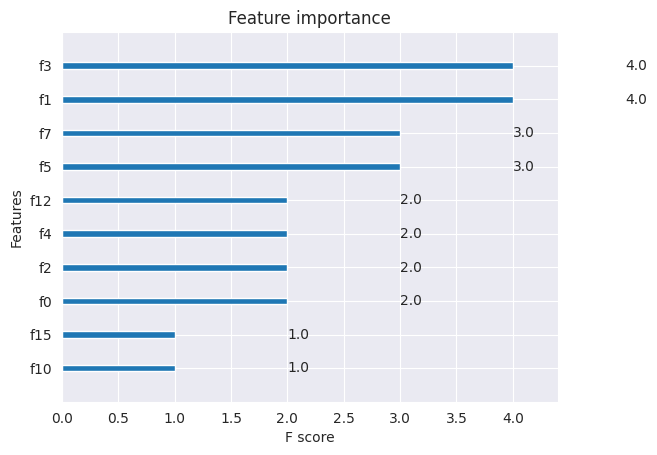

In [24]:
best_param['max_depth'] = int(best_param['max_depth'])
best_param['num_parallel_tree'] = int(best_param['num_parallel_tree'])
best_param['tree_method'] = 'approx'
best_param['grow_policy'] = 'depthwise'
best_param['sampling_method'] = 'uniform'
# best_param['colsample_bytree'] = best_param['colsample_bytree']

xgb_sklearn_parameters = {
    'n_estimators': 15000,
    'booster': 'gbtree',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'tree_method': 'approx',
    'grow_policy': 'lossguide',
    'sampling_method': 'gradient_based',
    'eval_metric': ['auc', 'error', 'logloss'],
    'early_stopping_rounds': 200,
    'learning_rate': 0.01,
    'gamma': 12.328606448220604,
    'subsample': 0.1,
    'colsample_bytree': 1.0,
    'max_depth': 1,
    'min_child_weight': 20.454791809195772
}

xgb_sklearn_parameters.update(best_param)

clf = xgb.XGBClassifier(**xgb_sklearn_parameters)
clf.fit(X_train, y_train,  eval_set=[(X_train, y_train)], verbose=50)
# clf.save_model('ewma_model_opp_adjusted.json')

xgb.plot_importance(clf)

In [32]:
def add_rolling_ewma(pbp_df, features, season, schedule_df):
    game_df = pbp_df.loc[pbp_df['season'] == season]
    pregame_data = pd.DataFrame()
    for i, x in schedule_df.iterrows():
        home = x['home_team']
        away = x['away_team']
        offense = game_df.loc[(game_df['posteam'] == home) | (game_df['posteam'] == away)]
        defense = game_df.loc[(game_df['defteam'] == home) | (game_df['defteam'] == away)]
        rushing_offense = offense.loc[offense['rush_attempt'] == 1].groupby(['posteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'posteam': 'team'})
        passing_offense = offense.loc[offense['pass_attempt'] == 1].groupby(['posteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'posteam': 'team'})
        rushing_defense = defense.loc[defense['rush_attempt'] == 1].groupby(['defteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'defteam': 'team'})
        passing_defense = defense.loc[defense['pass_attempt'] == 1].groupby(['defteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'defteam': 'team'})
        pregame = np.zeros(8)

        for i, (tm, stat_df) in enumerate(
                itertools.product([home, away], [rushing_offense, passing_offense, rushing_defense, passing_defense])):
            if stat_df.loc[stat_df['team'] == tm]['epa'].values.size == 0:
                print(stat_df)
                print(tm)
            ewma_value = ewma(stat_df.loc[stat_df['team'] == tm]['epa'].values, 20)
            pregame[i] = ewma_value

        pregame_df = pd.DataFrame()
        for x, y in zip(features, pregame):
            pregame_df[x] = [y]
        pregame_data = pd.concat([pregame_data, pregame_df], ignore_index=True)
    return pregame_data

def get_ewma_schedule(dataset_df, epa_df, features, rest_df):
    schedule = dataset_df.merge(rest_df, on=['game_id'])
    schedule = schedule[features].drop_duplicates().reset_index(
        drop=True).assign(
        home_team_win=lambda x: (x.home_score > x.away_score).astype(int))
    return schedule.merge(epa_df.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week']).merge(
        epa_df.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], suffixes=('_home', '_away'))

sched_df = nfl.import_schedules([2023])
sched_df.reset_index(drop=True, inplace=True)
sched_df['home_team_win'] = np.where(sched_df['home_score'] > sched_df['away_score'], 1, 0)
test_data = add_rolling_ewma(pbp_data, features, 2023, sched_df)

test_schedule = pd.concat([sched_df, test_data], axis=1)

league_passing_offense_epa = test_schedule.groupby(['season', 'week'], as_index=False)[['ewma_dynamic_window_passing_offense_home', 'ewma_dynamic_window_passing_offense_away']].mean()
league_passing_offense_epa['epa'] = league_passing_offense_epa[['ewma_dynamic_window_passing_offense_home', 'ewma_dynamic_window_passing_offense_away']].sum(axis=1)
league_passing_offense_epa = league_passing_offense_epa[['season', 'week', 'epa']]
league_passing_offense_epa['epa_shifted'] = league_passing_offense_epa['epa'].shift()
league_passing_offense_epa['ewma'] = league_passing_offense_epa['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
league_passing_offense_epa['ewma_dynamic_window'] = dynamic_window_ewma(league_passing_offense_epa).values

league_passing_defense_epa = test_schedule.groupby(['season', 'week'], as_index=False)[['ewma_dynamic_window_passing_defense_home', 'ewma_dynamic_window_passing_defense_away']].mean()
league_passing_defense_epa['epa'] = league_passing_defense_epa[['ewma_dynamic_window_passing_defense_home', 'ewma_dynamic_window_passing_defense_away']].sum(axis=1)
league_passing_defense_epa = league_passing_defense_epa[['season', 'week', 'epa']]
league_passing_defense_epa['epa_shifted'] = league_passing_defense_epa['epa'].shift()
league_passing_defense_epa['ewma'] = league_passing_defense_epa['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
league_passing_defense_epa['ewma_dynamic_window'] = dynamic_window_ewma(league_passing_defense_epa).values

league_rushing_offense_epa = test_schedule.groupby(['season', 'week'], as_index=False)[['ewma_dynamic_window_rushing_offense_home', 'ewma_dynamic_window_rushing_offense_away']].mean()
league_rushing_offense_epa['epa'] = league_rushing_offense_epa[['ewma_dynamic_window_rushing_offense_home', 'ewma_dynamic_window_rushing_offense_away']].sum(axis=1)
league_rushing_offense_epa = league_rushing_offense_epa[['season', 'week', 'epa']]
league_rushing_offense_epa['epa_shifted'] = league_rushing_offense_epa['epa'].shift()
league_rushing_offense_epa['ewma'] = league_rushing_offense_epa['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
league_rushing_offense_epa['ewma_dynamic_window'] = dynamic_window_ewma(league_rushing_offense_epa).values

league_rushing_defense_epa = test_schedule.groupby(['season', 'week'], as_index=False)[['ewma_dynamic_window_rushing_defense_home', 'ewma_dynamic_window_rushing_defense_away']].mean()
league_rushing_defense_epa['epa'] = league_rushing_defense_epa[['ewma_dynamic_window_rushing_defense_home', 'ewma_dynamic_window_rushing_defense_away']].sum(axis=1)
league_rushing_defense_epa = league_rushing_defense_epa[['season', 'week', 'epa']]
league_rushing_defense_epa['epa_shifted'] = league_rushing_defense_epa['epa'].shift()
league_rushing_defense_epa['ewma'] = league_rushing_defense_epa['epa_shifted'].transform(lambda x: x.ewm(min_periods=1, span=10).mean())
league_rushing_defense_epa['ewma_dynamic_window'] = dynamic_window_ewma(league_rushing_defense_epa).values

league_offense_epa = league_rushing_offense_epa.merge(league_passing_offense_epa, on=['season', 'week'], suffixes=('_league_rushing', '_league_passing'))
league_defense_epa = league_rushing_defense_epa.merge(league_passing_defense_epa, on=['season', 'week'], suffixes=('_league_rushing', '_league_passing'))

league_epa = league_offense_epa.merge(league_defense_epa, on=['season', 'week'], suffixes=('_offense', '_defense'))
league_epa['league_average_passing_epa'] = league_epa[['ewma_dynamic_window_league_passing_offense', 'ewma_dynamic_window_league_passing_defense']].sum(axis=1)
league_epa['league_average_rushing_epa'] = league_epa[['ewma_dynamic_window_league_rushing_offense', 'ewma_dynamic_window_league_rushing_defense']].sum(axis=1)

schedule_with_league_stats = pd.merge(test_schedule, league_epa, on=['season', 'week'], suffixes=('_schedule', '_league'))

schedule_with_league_stats['home_off_passing_adjustment_factor'] = schedule_with_league_stats['league_average_passing_epa'] - schedule_with_league_stats['ewma_dynamic_window_passing_defense_away']
schedule_with_league_stats['home_def_passing_adjustment_factor'] = schedule_with_league_stats['league_average_passing_epa'] - schedule_with_league_stats['ewma_dynamic_window_passing_offense_away']

schedule_with_league_stats['home_off_rushing_adjustment_factor'] = schedule_with_league_stats['league_average_rushing_epa'] - schedule_with_league_stats['ewma_dynamic_window_rushing_defense_away']
schedule_with_league_stats['home_def_rushing_adjustment_factor'] = schedule_with_league_stats['league_average_rushing_epa'] - schedule_with_league_stats['ewma_dynamic_window_rushing_offense_away']

schedule_with_league_stats['away_off_passing_adjustment_factor'] = schedule_with_league_stats['league_average_passing_epa'] - schedule_with_league_stats['ewma_dynamic_window_passing_defense_home']
schedule_with_league_stats['away_def_passing_adjustment_factor'] = schedule_with_league_stats['league_average_passing_epa'] - schedule_with_league_stats['ewma_dynamic_window_passing_offense_home']

schedule_with_league_stats['away_off_rushing_adjustment_factor'] = schedule_with_league_stats['league_average_rushing_epa'] - schedule_with_league_stats['ewma_dynamic_window_rushing_defense_home']
schedule_with_league_stats['away_def_rushing_adjustment_factor'] = schedule_with_league_stats['league_average_rushing_epa'] - schedule_with_league_stats['ewma_dynamic_window_rushing_offense_home']

schedule_with_league_stats['home_adjusted_off_passing_epa'] = schedule_with_league_stats['ewma_dynamic_window_passing_offense_home'] + schedule_with_league_stats['home_off_passing_adjustment_factor']
schedule_with_league_stats['home_adjusted_def_passing_epa'] = schedule_with_league_stats['ewma_dynamic_window_passing_defense_home'] + schedule_with_league_stats['home_def_passing_adjustment_factor']

schedule_with_league_stats['home_adjusted_off_rushing_epa'] = schedule_with_league_stats['ewma_dynamic_window_rushing_offense_home'] + schedule_with_league_stats['home_off_rushing_adjustment_factor']
schedule_with_league_stats['home_adjusted_def_rushing_epa'] = schedule_with_league_stats['ewma_dynamic_window_rushing_defense_home'] + schedule_with_league_stats['home_def_rushing_adjustment_factor']

schedule_with_league_stats['away_adjusted_off_passing_epa'] = schedule_with_league_stats['ewma_dynamic_window_passing_offense_away'] + schedule_with_league_stats['away_off_passing_adjustment_factor']
schedule_with_league_stats['away_adjusted_def_passing_epa'] = schedule_with_league_stats['ewma_dynamic_window_passing_defense_away'] + schedule_with_league_stats['away_def_passing_adjustment_factor']

schedule_with_league_stats['away_adjusted_off_rushing_epa'] = schedule_with_league_stats['ewma_dynamic_window_rushing_offense_away'] + schedule_with_league_stats['away_off_rushing_adjustment_factor']
schedule_with_league_stats['away_adjusted_def_rushing_epa'] = schedule_with_league_stats['ewma_dynamic_window_rushing_defense_away'] + schedule_with_league_stats['away_def_rushing_adjustment_factor']

schedule_with_league_stats

In [66]:
X_test = schedule_with_league_stats[features].to_numpy()
preds = clf.predict_proba(X_test)

schedule_with_league_stats['home_wp'] = preds[:, 1]
schedule_with_league_stats['away_wp'] = preds[:, 0]
schedule_with_league_stats['home_team_win'] = np.where(schedule_with_league_stats['result'] > 0, 1, 0)
schedule_with_league_stats['correct_pred'] = np.where(((schedule_with_league_stats['wp'] > 0.5) & (schedule_with_league_stats['home_team_win'] == 1)) | ((schedule_with_league_stats['wp'] < 0.5) & (schedule_with_league_stats['home_team_win'] == 0)), 1, 0)
schedule_with_league_stats[['game_id', 'result', 'home_wp', 'correct_pred']]

,game_id,result,home_wp,correct_pred
0,2023_01_DET_KC,-1.0,0.607633,0
1,2023_01_CAR_ATL,14.0,0.727470,1
2,2023_01_HOU_BAL,16.0,0.716183,1
3,2023_01_CIN_CLE,21.0,0.702155,1
4,2023_01_JAX_IND,-10.0,0.510084,0
...,...,...,...,...
279,2023_20_GB_SF,3.0,0.649682,1
280,2023_20_TB_DET,8.0,0.744574,1
281,2023_20_KC_BUF,-3.0,0.519375,0
282,2023_21_KC_BAL,NaN,0.563328,0


In [155]:
bal_data = schedule_with_league_stats.loc[(((schedule_with_league_stats['home_team'] == 'BAL') & (schedule_with_league_stats['home_wp'] < .6)) | ((schedule_with_league_stats['away_team'] == 'BAL') & (schedule_with_league_stats['away_wp'] < .6))) & (schedule_with_league_stats['result'].notna()), ['home_team', 'away_team', 'result', 'total', 'home_wp', 'away_wp', 'correct_pred']]
bal_wp = np.where(((bal_data['home_team'] == 'BAL') & (bal_data['result'] > 0)) | ((bal_data['away_team'] == 'BAL') & (bal_data['result'] < 0)), 1, 0).mean()
print(f"KC @ BAL: BAL wins when WP is < 60%: {round(100 * bal_wp, 2)}%")

kc_data = schedule_with_league_stats.loc[(((schedule_with_league_stats['home_team'] == 'KC') & (schedule_with_league_stats['home_wp'] < .5)) | ((schedule_with_league_stats['away_team'] == 'KC') & (schedule_with_league_stats['away_wp'] < .5))) & (schedule_with_league_stats['result'].notna()), ['home_team', 'away_team', 'result', 'total', 'home_wp', 'away_wp', 'correct_pred']]
kc_wp = np.where(((kc_data['home_team'] == 'BAL') & (kc_data['result'] > 0)) | ((kc_data['away_team'] == 'KC') & (kc_data['result'] < 0)), 1, 0).mean()
print(f"KC @ BAL: KC wins when WP is < 50%: {round(100 * kc_wp, 2)}%")

kc_bal  = schedule_with_league_stats.iloc[-2]
home_ewma_norm = kc_bal['home_wp'] / (kc_bal['home_wp'] + kc_bal['away_wp'])
away_ewma_norm = kc_bal['away_wp'] / (kc_bal['home_wp'] + kc_bal['away_wp'])
home_win_prob = (bal_wp * home_ewma_norm) / ((bal_wp * home_ewma_norm) + ((kc_wp) * away_ewma_norm))
away_win_prob = (kc_wp * away_ewma_norm) / ((bal_wp * home_ewma_norm) + ((kc_wp) * away_ewma_norm))
print(f"KC @ BAL: KC WP: {round(100 * away_win_prob, 2)}%, BAL WP: {round(100 * home_win_prob, 2)}%")
print(f"KC @ BAL: Recommended Spread: BAL {bal_data['result'].mean()}")
print(f"KC @ BAL: Recommended ATS: KC {-kc_data['result'].mean()}")

bal_kc_total = (bal_data['total'].mean() + kc_data['total'].mean()) / 2
print(f"KC @ BAL: O/U Line: {kc_bal['total_line']}, Predicted Total: {bal_kc_total}")
print(f"KC @ BAL: Recommended Total: {np.where(bal_kc_total > kc_bal['total_line'], 'over', 'under')}")

KC @ BAL: BAL wins when WP is < 60%: 100.0%
KC @ BAL: KC wins when WP is < 50%: 80.0%
KC @ BAL: KC WP: 38.28%, BAL WP: 61.72%
KC @ BAL: Recommended Spread: BAL -3.4
KC @ BAL: Recommended ATS: KC 5.4
KC @ BAL: O/U Line: 44.5, Predicted Total: 44.0
KC @ BAL: Recommended Total: under


In [159]:
sf_data = schedule_with_league_stats.loc[(((schedule_with_league_stats['home_team'] == 'SF') & (schedule_with_league_stats['home_wp'] < .7)) | ((schedule_with_league_stats['away_team'] == 'SF') & (schedule_with_league_stats['away_wp'] < .7))) & (schedule_with_league_stats['result'].notna()), ['home_team', 'away_team', 'result', 'total', 'home_wp', 'away_wp', 'correct_pred']]
sf_wp = np.where(((sf_data['home_team'] == 'SF') & (sf_data['result'] > 0)) | ((sf_data['away_team'] == 'SF') & (sf_data['result'] < 0)), 1, 0).mean()
print(f"DET @ SF: SF wins when WP < 70%: {round( 100 * sf_wp, 2)}%")

det_data = schedule_with_league_stats.loc[(((schedule_with_league_stats['home_team'] == 'DET') & (schedule_with_league_stats['home_wp'] < .5)) | ((schedule_with_league_stats['away_team'] == 'DET') & (schedule_with_league_stats['away_wp'] < .6))) & (schedule_with_league_stats['result'].notna()), ['home_team', 'away_team', 'result', 'total', 'home_wp', 'away_wp', 'correct_pred']]
det_wp = np.where(((det_data['home_team'] == 'DET') & (det_data['result'] > 0)) | ((det_data['away_team'] == 'DET') & (det_data['result'] < 0)), 1, 0).mean()
print(f"DET @ SF: DET wins when WP < 50%: {round(100 * det_wp, 2)}%")

sf_det  = schedule_with_league_stats.iloc[-1]
home_ewma_norm = sf_det['home_wp'] / (sf_det['home_wp'] + sf_det['away_wp'])
away_ewma_norm = sf_det['away_wp'] / (sf_det['home_wp'] + sf_det['away_wp'])
home_win_prob = (sf_wp * home_ewma_norm) / ((sf_wp * home_ewma_norm) + ((det_wp) * away_ewma_norm))
away_win_prob = (det_wp * away_ewma_norm) / ((sf_wp * home_ewma_norm) + ((det_wp) * away_ewma_norm))
print(f"DET @ SF: SF WP: {round(100 * home_win_prob, 2)}%, DET WP: {round(100 * away_win_prob, 2)}%")
print(f"DET @ SF: Recommended Spread: SF {sf_data['result'].mean()}")
print(f"DET @ SF: Recommended ATS: DET {-sf_data['result'].mean()}")

sf_det_total = round((sf_data['total'].mean() + det_data['total'].mean()) / 2)
print(f"DET @ SF: O/U Line: {sf_det['total_line']}, Predicted Total: {sf_det_total}")
print(f"DET @ SF: Recommended Total: {np.where(sf_det_total > sf_det['total_line'], 'over', 'under')}")

DET @ SF: SF wins when WP < 70%: 70.0%
DET @ SF: DET wins when WP < 50%: 66.67%
DET @ SF: SF WP: 65.5%, DET WP: 34.5%
DET @ SF: Recommended Spread: SF -8.0
DET @ SF: Recommended ATS: DET 8.0
DET @ SF: O/U Line: 51.0, Predicted Total: 45
DET @ SF: Recommended Total: under


In [395]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

schedules = nfl.import_schedules(seasons)
schedules = nfl.clean_nfl_data(schedules)
schedules[['home_team', 'away_team']] = schedules[['home_team', 'away_team']].replace('OAK', 'LV')
schedules[['home_team', 'away_team']] = schedules[['home_team', 'away_team']].replace('SD', 'LAC')
schedules[['home_team', 'away_team']] = schedules[['home_team', 'away_team']].replace('STL', 'LAR')
schedules[['home_team', 'away_team']] = schedules[['home_team', 'away_team']].replace('JAC', 'JAX')
schedules[['home_team', 'away_team']] = schedules[['home_team', 'away_team']].replace('LAR', 'LA')


def add_rolling_ewma(df_tuple):
    df = df_tuple[0]
    features = df_tuple[1]
    season = df_tuple[2]
    bet_lines_df = df_tuple[3]
    game_df = df.loc[df['season'] == season]
    pregame_data = pd.DataFrame()
    for i, x in bet_lines_df.iterrows():
        home = x['home_team']
        away = x['away_team']
        offense = game_df.loc[(game_df['posteam'] == home) | (game_df['posteam'] == away)]
        defense = game_df.loc[(game_df['defteam'] == home) | (game_df['defteam'] == away)]
        rushing_offense = offense.loc[offense['rush_attempt'] == 1].groupby(['posteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'posteam': 'team'})
        passing_offense = offense.loc[offense['pass_attempt'] == 1].groupby(['posteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'posteam': 'team'})
        rushing_defense = defense.loc[defense['rush_attempt'] == 1].groupby(['defteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'defteam': 'team'})
        passing_defense = defense.loc[defense['pass_attempt'] == 1].groupby(['defteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'defteam': 'team'})
        pregame = np.zeros(8)

        for i, (tm, stat_df) in enumerate(
                itertools.product([home, away], [rushing_offense, passing_offense, rushing_defense, passing_defense])):
            if stat_df.loc[stat_df['team'] == tm]['epa'].values.size == 0:
                print(stat_df)
                print(tm)
            ewma_value = ewma(stat_df.loc[stat_df['team'] == tm]['epa'].values, 20)
            pregame[i] = ewma_value

        pregame_df = pd.DataFrame()
        for x, y in zip(features, pregame):
            pregame_df[x] = [y]
        pregame_data = pd.concat([pregame_data, pregame_df], ignore_index=True)
    return pregame_data

train_schedules = schedules.loc[schedules['result'].notna()]

In [397]:
from multiprocessing import Pool

with Pool(16) as pool:
    # group by season
    grouped = pbp_data.groupby('season')
    # create a list of tuples with season, file_prefix, and the dataframe
    df_tuples = [(group, features, season, schedules.loc[schedules['season'] == season]) for season, group in grouped]
    schedule_ewma_list = pool.map(add_rolling_ewma, df_tuples)

schedule_ewma = pd.concat(schedule_ewma_list, ignore_index=True)
    


In [192]:
X = schedule_ewma
X['spread_line'] = train_schedules['spread_line']
X['total_line'] = train_schedules['total_line']
X['home_rest'] = train_schedules['home_rest']
X['away_rest'] = train_schedules['away_rest']
X['wp'] = clf.predict_proba(schedule_ewma[features])[:,1]
y = train_schedules['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

mlp = MLPRegressor(hidden_layer_sizes=(64, 13), max_iter=15000, batch_size=30, alpha=0.01,
                   solver='lbfgs', activation="identity", random_state=21, learning_rate="adaptive", tol=0.000000001)
# mlp = MLPRegressor(hidden_layer_sizes=(64, 9), max_iter=5000, alpha=0.0001,
#                    solver='lbfgs', activation="identity", verbose=10, random_state=21, tol=0.000000001)

mlp.fit(X_train, y_train)

/home/dev/.virtualenvs/nfl-data-models/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


MLPRegressor(activation='identity', alpha=0.01, batch_size=30,
             hidden_layer_sizes=(64, 13), learning_rate='adaptive',
             max_iter=15000, random_state=21, solver='lbfgs', tol=1e-09)

In [73]:
sched_2023 = schedules.loc[schedules['season'] == 2023].reset_index(drop=True)
test_ewma = add_rolling_ewma(pbp_data, features, sched_2023)

ValueError: Input X contains NaN.
MLPRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [237]:
sched_2023 = schedules.loc[schedules['season'] == 2023].reset_index(drop=True)
test_ewma['spread_line'] = sched_2023['spread_line']
test_ewma['total_line'] = sched_2023['total_line']
test_ewma['home_rest'] = sched_2023['home_rest']
test_ewma['away_rest'] = sched_2023['away_rest']
test_ewma['wp'] = clf.predict_proba(test_ewma[features])[:,1]

/home/dev/.virtualenvs/nfl-data-models/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [296]:
y_pred_2023 = mlp.predict(test_ewma)

sched_2023['pred_result'] = y_pred_2023.round()
sched_2023['wp'] = test_ewma['wp']

def who_is_favored_to_win(df):
    return np.where(df['spread_line'] > 0, 'home_team', 'away_team')

def get_favorite_win_probability(df):
    return np.where(who_is_favored_to_win(df) == 'home_team', df['wp'], 1 - df['wp'])

def get_win_probability_quantile(df, condition, accuracy):
    return df.loc[condition, 'wp'].quantile(accuracy)


def get_spread_history(df):
    return df['result'] > df['spread_line']


def get_likelihood_to_cover_spread(df, accuracy):
    return get_win_probability_quantile(df, get_spread_history(df), accuracy)

def get_favorite_spread_line(df):
    return np.where(who_is_favored_to_win(df) == 'home_team', df['spread_line'], -df['spread_line'])

def get_favorite_predicted_spread_line(df):
    return np.where(who_is_favored_to_win(df) == 'home_team', df['pred_result'], -df['pred_result'])

def who_is_the_underdog(df):
    return np.where(df['spread_line'] > 0, 'away_team', 'home_team')

def get_underdog_win_probability(df):
    return np.where(who_is_the_underdog(df) == 'home_team', df['wp'], 1 - df['wp'])

def get_underdog_spread_line(df):
    return np.where(who_is_the_underdog(df) == 'home_team', df['spread_line'], -df['spread_line'])

def get_underdog_predicted_spread_line(df):
    return np.where(who_is_the_underdog(df) == 'home_team', df['pred_result'], -df['pred_result'])

def favorite_could_win(df, accuracy):
    return get_favorite_win_probability(df) > get_likelihood_to_cover_spread(df, accuracy)

def underdog_could_win(df, accuracy):
    return get_underdog_win_probability(df) > get_likelihood_to_cover_spread(df, accuracy)

# def home_team_could_win(df, fave_threshold):
#     return df['wp'] > fave_threshold

# def home_team_could_lose(df, underdog_threshold):
#     return df['wp'] < underdog_threshold
    
# def predicted_favorite_is_home_team(df):
#     return df['pred_result'] > 0

# def predicted_underdog_is_home_team(df):
#     return df['pred_result'] < 0

def favorite_spread_line_higher_than_expected(df):
    return get_favorite_spread_line(df) > get_favorite_predicted_spread_line(df)

def favorite_spread_line_lower_than_expected(df):
    return get_favorite_spread_line(df) < get_favorite_predicted_spread_line(df)

def underdog_spread_line_higher_than_expected(df):
    return get_underdog_spread_line(df) > get_underdog_predicted_spread_line(df)

def underdog_spread_line_lower_than_expected(df):
    return get_underdog_spread_line(df) < get_underdog_predicted_spread_line(df)

def predicted_underdog_spread_line_available(df):
    return abs(get_underdog_predicted_spread_line(df) - get_underdog_spread_line(df)) < 2

def predicted_underdog_spread_line_unavailable(df):
    return abs(get_underdog_predicted_spread_line(df) - get_underdog_spread_line(df)) >= 2

# def favorite_spread_line_lower_than_expected(df):
#     return df['spread_line'] < df['pred_result']

def predicted_favorite_spread_line_available(df):
    return abs(get_favorite_predicted_spread_line(df) - get_favorite_spread_line(df)) < 2

def predicted_favorite_spread_line_unavailable(df):
    return abs(get_favorite_predicted_spread_line(df) - get_favorite_spread_line(df)) >= 2
    
def favorite_will_win_but_not_cover_spread(df, accuracy):
    return np.where(favorite_could_win(df, accuracy) & favorite_spread_line_higher_than_expected(df), True, False)

def favorite_will_win_and_cover_spread(df, accuracy):
    return np.where((favorite_could_win(df, accuracy)) & favorite_spread_line_lower_than_expected(df), True, False)

def favorite_will_win_and_cover_alt_spread(df, accuracy):
    return np.where(favorite_could_win(df, accuracy) & favorite_spread_line_higher_than_expected(df) & predicted_favorite_spread_line_available(df), True, False)

def favorite_will_win_but_not_cover_alt_spread(df, accuracy):
    return np.where(favorite_could_win(df, accuracy) & favorite_spread_line_higher_than_expected(df) & predicted_favorite_spread_line_unavailable(df), True, False)

def underdog_will_win(df, accuracy):
    return np.where(underdog_could_win(df, accuracy) & underdog_spread_line_lower_than_expected(df), True, False)

def underdog_will_lose_but_cover_spread(df, accuracy):
    return np.where(underdog_could_win(df, accuracy) & underdog_spread_line_higher_than_expected(df), True, False)

def underdog_will_lose_but_cover_alt_spread(df, accuracy):
    return np.where(underdog_could_win(df, accuracy) & underdog_spread_line_higher_than_expected(df) & predicted_underdog_spread_line_available(df), True, False)

def underdog_will_lose_and_not_cover_alt_spread(df, accuracy):
    return np.where(underdog_could_win(df, accuracy) & underdog_spread_line_lower_than_expected(df) & predicted_underdog_spread_line_unavailable(df), True, False)

def underdog_will_lose_and_not_cover_spread(df, accuracy):
    return np.where(underdog_could_win(df, accuracy) & underdog_spread_line_lower_than_expected(df), True, False)

sched_2023['recommended_bet'] = np.nan
sched_2023.loc[favorite_will_win_and_cover_spread(sched_2023, .1), 'recommended_bet'] = sched_2023.loc[favorite_will_win_and_cover_spread(sched_2023, .6), 'spread_line']
sched_2023.loc[favorite_will_win_and_cover_alt_spread(sched_2023, .1), 'recommended_bet'] = sched_2023.loc[favorite_will_win_and_cover_alt_spread(sched_2023, .6), 'pred_result']
sched_2023.loc[favorite_will_win_but_not_cover_spread(sched_2023, .1), 'recommended_bet'] = -1 * sched_2023.loc[favorite_will_win_but_not_cover_spread(sched_2023, .6), 'spread_line']
sched_2023.loc[favorite_will_win_but_not_cover_alt_spread(sched_2023, .1), 'recommended_bet'] = -1 * sched_2023.loc[favorite_will_win_but_not_cover_alt_spread(sched_2023, .6), 'spread_line']
sched_2023.loc[underdog_will_win(sched_2023, .1), 'recommended_bet'] = -1 * sched_2023.loc[underdog_will_win(sched_2023, .6), 'spread_line']
sched_2023.loc[underdog_will_lose_but_cover_spread(sched_2023, .1), 'recommended_bet'] = -1 * sched_2023.loc[underdog_will_lose_but_cover_spread(sched_2023, .6), 'spread_line']
sched_2023.loc[underdog_will_lose_but_cover_alt_spread(sched_2023, .1), 'recommended_bet'] = -1 * sched_2023.loc[underdog_will_lose_but_cover_alt_spread(sched_2023, .6), 'pred_result']
sched_2023.loc[underdog_will_lose_and_not_cover_alt_spread(sched_2023, .1), 'recommended_bet'] = sched_2023.loc[underdog_will_lose_and_not_cover_alt_spread(sched_2023, .6), 'spread_line']
sched_2023.loc[underdog_will_lose_and_not_cover_spread(sched_2023, .1), 'recommended_bet'] = sched_2023.loc[underdog_will_lose_and_not_cover_spread(sched_2023, .6), 'spread_line']
sched_2023['correct'] = np.where((sched_2023['recommended_bet'].notna()) & (sched_2023['recommended_bet'] < sched_2023['result']), 1, 0)
sched_2023[['game_id', 'game_type', 'home_team', 'home_score', 'away_team', 'away_score', 'total', 'total_line', 'spread_line', 'result', 'pred_result', 'wp', 'recommended_bet', 'correct']]

,game_id,game_type,home_team,home_score,away_team,away_score,total,total_line,spread_line,result,pred_result,wp,recommended_bet,correct
0,2023_01_DET_KC,REG,KC,20.0,DET,21.0,41.0,53.0,4.0,-1.0,6.0,0.646745,4.0,0
1,2023_01_CAR_ATL,REG,ATL,24.0,CAR,10.0,34.0,40.5,3.5,14.0,3.0,0.586244,-3.5,1
2,2023_01_HOU_BAL,REG,BAL,25.0,HOU,9.0,34.0,43.5,9.5,16.0,12.0,0.684350,9.5,1
3,2023_01_CIN_CLE,REG,CLE,24.0,CIN,3.0,27.0,46.5,-1.0,21.0,-3.0,0.448519,NaN,0
4,2023_01_JAX_IND,REG,IND,21.0,JAX,31.0,52.0,45.5,-4.0,-10.0,-4.0,0.594776,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,2023_20_GB_SF,DIV,SF,24.0,GB,21.0,45.0,50.5,10.5,3.0,10.0,0.530985,NaN,0
280,2023_20_TB_DET,DIV,DET,31.0,TB,23.0,54.0,49.5,6.0,8.0,4.0,0.512820,NaN,0
281,2023_20_KC_BUF,DIV,BUF,24.0,KC,27.0,51.0,45.5,2.5,-3.0,3.0,0.493474,NaN,0
282,2023_21_KC_BAL,CON,BAL,NaN,KC,NaN,NaN,44.5,3.5,NaN,5.0,0.546861,NaN,0


In [297]:
sched_2023.loc[sched_2023['result'].notna(), 'correct'].mean()

0.19148936170212766

In [283]:
np.percentile(sched_2023.loc[get_spread_history(sched_2023), 'wp'], 80)

0.6187936127128825

In [293]:
sched_2023.loc[favorite_will_win_and_cover_spread(sched_2023, .1), 'wp']

0      0.646745
2      0.684350
3      0.448519
11     0.674023
13     0.616431
         ...   
273    0.692816
278    0.684350
281    0.493474
282    0.546861
283    0.610223
Name: wp, Length: 113, dtype: float64

### EWMA Model - XGBClassifier with Sklearn train_test_split

In [82]:
schedule_df = schedule.dropna()
x = schedule_df[features].values
y = schedule_df[target].values

xgb_sklearn_parameters = {
    'n_estimators': 15000,
    'booster': 'gbtree',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'tree_method': 'approx',
    'grow_policy': 'lossguide',
    'sampling_method': 'gradient_based',
    'eval_metric': ['auc', 'error', 'logloss'],
    'early_stopping_rounds': 200,
    'learning_rate': 0.01,
    'gamma': 12.328606448220604,
    'subsample': 0.1,
    'colsample_bytree': 1.0,
    'max_depth': 1,
    'min_child_weight': 20.454791809195772
}

X_train, X_test, y_train, y_test, clf = get_data_with_features_xgb_regressor(X, y, xgb_sklearn_parameters)
clf.fit(X_train, y_train,  eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)

[0]	validation_0-auc:0.54788	validation_0-error:0.43940	validation_0-logloss:0.68557	validation_1-auc:0.53080	validation_1-error:0.42857	validation_1-logloss:0.68303
[50]	validation_0-auc:0.65796	validation_0-error:0.43961	validation_0-logloss:0.67341	validation_1-auc:0.64408	validation_1-error:0.42795	validation_1-logloss:0.67206
[100]	validation_0-auc:0.66523	validation_0-error:0.40025	validation_0-logloss:0.66464	validation_1-auc:0.65074	validation_1-error:0.39938	validation_1-logloss:0.66458
[150]	validation_0-auc:0.66972	validation_0-error:0.38658	validation_0-logloss:0.65837	validation_1-auc:0.65849	validation_1-error:0.38509	validation_1-logloss:0.65810
[200]	validation_0-auc:0.67303	validation_0-error:0.37642	validation_0-logloss:0.65377	validation_1-auc:0.66108	validation_1-error:0.37640	validation_1-logloss:0.65413
[250]	validation_0-auc:0.67373	validation_0-error:0.36897	validation_0-logloss:0.64951	validation_1-auc:0.66101	validation_1-error:0.37391	validation_1-logloss:0.6

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device='cuda', early_stopping_rounds=200,
              enable_categorical=False, eval_metric=['auc', 'error', 'logloss'],
              feature_types=None, gamma=12.328606448220604,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=20.454791809195772, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=15000, n_jobs=None, num_parallel_tree=None,
              random_state=None, ...)

In [97]:
scores = clf.evals_result()
accuracy = clf.score(X_test, y_test)
print("Log Loss: " + str(round(sum(scores['validation_1']['logloss']) / len(scores['validation_1']['logloss']), 4)))
print("Error: " + str(round(sum(scores['validation_1']['error']) / len(scores['validation_1']['error']), 4)))
print("Area Under Curve: " + str(round(sum(scores['validation_1']['auc']) / len(scores['validation_1']['auc']), 4))) 
print("Accuracy: " + str(round(accuracy * 100, 2)) + "%")

Log Loss: 0.6449
Error: 0.3815
Area Under Curve: 0.6631
Accuracy: 62.61%


### EWMA Model - XGBClassifier with StratifiedKFold Cross Validation

In [121]:
X = schedule_df[features].values
y = schedule_df[target].values
X_train, X_test, y_train, y_test = create_sk_stratifiedkfolds(X, y, 5)
clf = xgb.XGBClassifier(**xgb_sklearn_parameters)
clf.fit(X_train, y_train,  eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)

[0]	validation_0-auc:0.53876	validation_0-error:0.43670	validation_0-logloss:0.68491	validation_1-auc:0.53643	validation_1-error:0.43667	validation_1-logloss:0.68492
[50]	validation_0-auc:0.65491	validation_0-error:0.43670	validation_0-logloss:0.67317	validation_1-auc:0.65501	validation_1-error:0.43667	validation_1-logloss:0.67376
[100]	validation_0-auc:0.66386	validation_0-error:0.40602	validation_0-logloss:0.66534	validation_1-auc:0.66448	validation_1-error:0.42968	validation_1-logloss:0.66647
[150]	validation_0-auc:0.66817	validation_0-error:0.38291	validation_0-logloss:0.65894	validation_1-auc:0.66822	validation_1-error:0.39394	validation_1-logloss:0.66045
[200]	validation_0-auc:0.67219	validation_0-error:0.37204	validation_0-logloss:0.65395	validation_1-auc:0.67056	validation_1-error:0.38539	validation_1-logloss:0.65613
[250]	validation_0-auc:0.67458	validation_0-error:0.36932	validation_0-logloss:0.64986	validation_1-auc:0.67334	validation_1-error:0.38228	validation_1-logloss:0.6

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device='cuda', early_stopping_rounds=200,
              enable_categorical=False, eval_metric=['auc', 'error', 'logloss'],
              feature_types=None, gamma=12.328606448220604,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=20.454791809195772, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=15000, n_jobs=None, num_parallel_tree=None,
              random_state=None, ...)

In [122]:
scores = clf.evals_result()
accuracy = clf.score(X_test, y_test)
print("Log Loss: " + str(round(sum(scores['validation_1']['logloss']) / len(scores['validation_1']['logloss']), 4)))
print("Error: " + str(round(sum(scores['validation_1']['error']) / len(scores['validation_1']['error']), 4)))
print("Area Under Curve: " + str(round(sum(scores['validation_1']['auc']) / len(scores['validation_1']['auc']), 4))) 
print("Accuracy: " + str(round(accuracy * 100, 2)) + "%")

Log Loss: 0.6461
Error: 0.3712
Area Under Curve: 0.6709
Accuracy: 64.1%


### EWMA Model - XGBClassifier

In [5]:
def get_ewma_schedule(dataset_df, epa_df, features, rest_df):
    schedule = dataset_df.merge(rest_df, on=['game_id'])
    schedule = schedule[features].drop_duplicates().reset_index(
        drop=True).assign(
        home_team_win=lambda x: (x.home_score > x.away_score).astype(int))
    return schedule.merge(epa_df.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week']).merge(
        epa_df.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], suffixes=('_home', '_away'))

schedule_df = nfl.import_schedules(seasons)
rest_df = schedule_df[['game_id', 'game_type', 'home_rest', 'away_rest']]

wp_model_features = ['div_game', 'temp', 'wind', 'spread_line', 'total_line', 'home_rest', 'away_rest']
categorical_features = ['location', 'game_type', 'home_team', 'away_team', 'roof', 'surface']
wp_model_features.extend(categorical_features)
schedule_features = ['game_id', 'season', 'week', 'home_score', 'away_score', 'total', 'result']
schedule_features.extend(wp_model_features)
schedule = get_ewma_schedule(pbp_data, epa, schedule_features, rest_df)
schedule[categorical_features] = schedule[categorical_features].astype('category')
schedule

,game_id,season,week,home_score,away_score,total,result,div_game,temp,wind,...,ewma_passing_offense_away,ewma_dynamic_window_passing_offense_away,epa_rushing_defense_away,epa_shifted_rushing_defense_away,ewma_rushing_defense_away,ewma_dynamic_window_rushing_defense_away,epa_passing_defense_away,epa_shifted_passing_defense_away,ewma_passing_defense_away,ewma_dynamic_window_passing_defense_away
0,2000_01_ARI_NYG,2000,1,21,16,37,5,1,80.0,3.0,...,-0.172588,-0.172588,0.166199,0.363190,0.086016,0.086016,-0.009200,0.269840,0.115978,0.115978
1,2000_01_BAL_PIT,2000,1,0,16,16,-16,1,74.0,8.0,...,-0.115063,-0.115063,-0.499352,-0.241927,-0.205927,-0.205927,-0.216112,-0.314740,-0.201637,-0.201637
2,2000_01_CAR_WAS,2000,1,20,17,37,3,0,80.0,0.0,...,0.187536,0.187536,-0.006129,0.060270,0.057299,0.057299,0.147979,-0.368611,0.001226,0.001226
3,2000_01_CHI_MIN,2000,1,30,27,57,3,1,NaN,NaN,...,-0.079708,-0.079708,0.283000,-0.130394,-0.057451,-0.057451,0.124496,0.365886,0.106318,0.106318
4,2000_01_DEN_STL,2000,1,41,36,77,5,0,NaN,NaN,...,-0.018102,-0.018102,-0.106372,-0.110182,-0.091645,-0.091645,0.400226,-0.078273,-0.086851,-0.086851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6433,2023_19_GB_DAL,2023,19,32,48,80,-16,0,NaN,NaN,...,0.270580,0.192492,0.313375,-0.124136,-0.042600,-0.031197,-0.052650,-0.061583,0.031262,0.027345
6434,2023_19_LA_DET,2023,19,24,23,47,1,0,NaN,NaN,...,0.111827,0.059137,-0.044500,0.114183,-0.046130,-0.041577,0.373946,0.190483,0.025825,0.015835
6435,2023_19_MIA_KC,2023,19,26,7,33,19,0,-4.0,19.0,...,0.101003,0.111990,-0.125088,0.045016,-0.137848,-0.120051,0.196790,0.095996,0.152855,0.059733
6436,2023_19_PHI_TB,2023,19,32,9,41,23,0,NaN,NaN,...,0.041925,0.064277,0.011608,-0.075730,0.056847,0.028652,0.288088,0.225062,0.120206,0.069567


In [6]:
def get_ewma_features(df, additional_features=None):
    features = [column for column in df.columns if 'ewma' in column and 'dynamic' in column]
    if additional_features:
        features.extend(additional_features)
    return features


features = get_ewma_features(schedule, wp_model_features)
target = 'home_team_win'
features

['ewma_dynamic_window_rushing_offense_home',
 'ewma_dynamic_window_passing_offense_home',
 'ewma_dynamic_window_rushing_defense_home',
 'ewma_dynamic_window_passing_defense_home',
 'ewma_dynamic_window_rushing_offense_away',
 'ewma_dynamic_window_passing_offense_away',
 'ewma_dynamic_window_rushing_defense_away',
 'ewma_dynamic_window_passing_defense_away',
 'div_game',
 'temp',
 'wind',
 'spread_line',
 'total_line',
 'home_rest',
 'away_rest',
 'location',
 'game_type',
 'home_team',
 'away_team',
 'roof',
 'surface']

In [77]:
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK, hp, tpe, Trials, fmin

def create_stratifiedkfolds(X, y, num_splits):
    folds = StratifiedKFold(n_splits=num_splits)
    for train_index, test_index in folds.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    return X_train, X_test, y_train, y_test

X = schedule[features]
y = schedule[target]

X_train, X_test, y_train, y_test = create_stratifiedkfolds(X, y, 5)

monotone_constraints = {
    # 'ewma_dynamic_window_rushing_offense_home': 0,
    #  'ewma_dynamic_window_passing_offense_home': 0,
    #  'ewma_dynamic_window_rushing_defense_home': 0,
    #  'ewma_dynamic_window_passing_defense_home': 0,
    #  'ewma_dynamic_window_rushing_offense_away': 0,
    #  'ewma_dynamic_window_passing_offense_away': 0,
    #  'ewma_dynamic_window_rushing_defense_away': 0,
    #  'ewma_dynamic_window_passing_defense_away': 0,
    #  'div_game': 0,
    #  'temp': 0,
    #  'wind': 0,
    #  'spread_line': -1,
     # 'total_line': 0,
     'home_rest': 1,
     # 'away_rest': -1,
}

xgb_sklearn_parameters = {
    'n_estimators': 15000,
    'booster': 'gbtree',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'tree_method': 'approx',
    'grow_policy': 'lossguide',
    'sampling_method': 'gradient_based',
    'eval_metric': ['auc', 'error', 'logloss'],
    'early_stopping_rounds': 200,
    'learning_rate': 0.01,
    'gamma': 12.328606448220604,
    'subsample': 0.1,
    'colsample_bytree': 1.0,
    'max_depth': 1,
    'min_child_weight': 20.454791809195772,
    'enable_categorical': True
    # 'monotone_constraints': monotone_constraints
}

def objective_function(params):
    params['max_depth'] = int(params['max_depth'])
    params['num_parallel_tree'] = int(params['num_parallel_tree'])
    clf = xgb.XGBClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_log_loss', fit_params={'eval_set': [(X_train, y_train)], 'verbose': False}).mean()
    return {'loss': -score, 'status': STATUS_OK}

space= {
    'learning_rate': hp.loguniform('learning_rate', 0.1, 1),
    'max_depth': hp.quniform('max_depth', 1, 100, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 100, 1),
    'n_estimators': 15000,
    'gamma': hp.uniform('gamma', 0, 20),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    'booster': 'gbtree',
    'sampling_method': hp.choice('sampling_method', ['uniform', 'gradient_based']),
    'grow_policy': hp.choice('grow_policy', ['depthwise', 'lossguide']),
    'eval_metric': 'logloss',
    'early_stopping_rounds': hp.quniform('early_stopping_rounds', 50, 200, 1),
    'device': 'cuda',
    'objective': 'binary:logistic',
    'tree_method': hp.choice('tree_method', ['approx', 'hist']),
    'num_parallel_tree': hp.quniform('num_parallel_tree', 1, 3, 1),
    'enable_categorical': True
}

trials = Trials()

best_param = fmin(objective_function, space, algo=tpe.suggest, max_evals=500, trials=trials)

100%|██████████| 500/500 [4:43:13<00:00, 33.99s/trial, best loss: 0.6186277966636488]    


In [78]:
best_param

{'colsample_by_tree': 0.5635423924385589,
 'early_stopping_rounds': 111.0,
 'gamma': 10.555089371778394,
 'grow_policy': 0,
 'learning_rate': 1.116031074771482,
 'max_depth': 95.0,
 'min_child_weight': 85.0,
 'num_parallel_tree': 3.0,
 'sampling_method': 1,
 'subsample': 0.9931052761300065,
 'tree_method': 0}

[0]	validation_0-auc:0.71090	validation_0-error:0.34654	validation_0-logloss:0.61887


/home/dev/.virtualenvs/nfl-data-models/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:40:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_by_tree" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	validation_0-auc:0.71642	validation_0-error:0.33566	validation_0-logloss:0.61301
[100]	validation_0-auc:0.71642	validation_0-error:0.33566	validation_0-logloss:0.61304
[150]	validation_0-auc:0.71642	validation_0-error:0.33566	validation_0-logloss:0.61301
[200]	validation_0-auc:0.71642	validation_0-error:0.33566	validation_0-logloss:0.61302
[250]	validation_0-auc:0.71642	validation_0-error:0.33566	validation_0-logloss:0.61305
[269]	validation_0-auc:0.71642	validation_0-error:0.33566	validation_0-logloss:0.61302


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

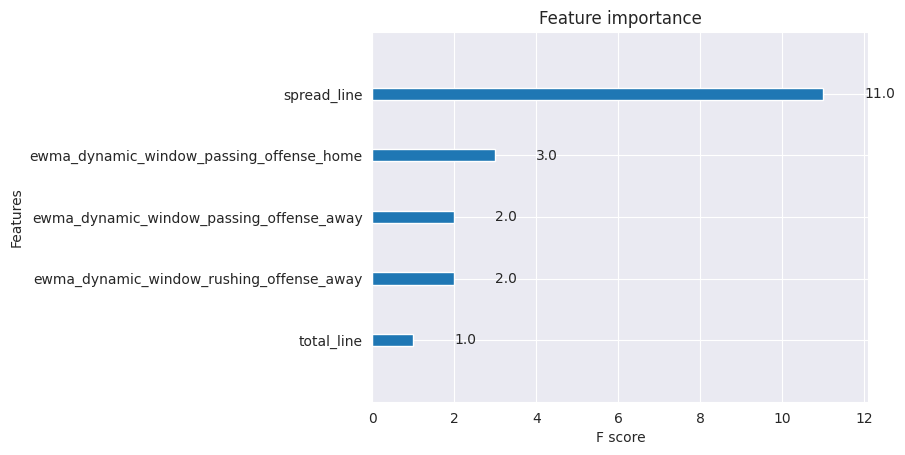

In [85]:
best_param['max_depth'] = int(best_param['max_depth'])
best_param['num_parallel_tree'] = int(best_param['num_parallel_tree'])
best_param['tree_method'] = 'approx'
best_param['grow_policy'] = 'depthwise'
best_param['sampling_method'] = 'gradient_based'
best_param['colsample_bytree'] = best_param['colsample_by_tree']
xgb_sklearn_parameters.update(best_param)

clf = xgb.XGBClassifier(**xgb_sklearn_parameters)
clf.fit(X_train, y_train,  eval_set=[(X_test, y_test)], verbose=50)
clf.save_model('ewma_model_xgbclf_stratkfold.json')

xgb.plot_importance(clf)

In [96]:
def predict_season(df, season, clf, features):
    season_df = df.loc[(df['season'] == season)].assign(
        predicted_winner = lambda x: clf.predict(x[features]),
        home_team_win_probability = lambda x: clf.predict_proba(x[features])[:,1])[
        ['game_id','season', 'week', 'location', 'game_type','home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]
    season_df['actual_winner'] = season_df.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
    season_df['predicted_winner'] = season_df.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
    season_df['win_probability'] = season_df.apply(
        lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
    season_df['correct_prediction'] = (season_df['predicted_winner'] == season_df['actual_winner']).astype(int)
    season_df = season_df.drop(columns=['home_team_win_probability', 'home_team_win'])
    
    return season_df.sort_values(by='win_probability', ascending=False).reset_index(drop=True)


def get_predictions(df, season, clf, features, bet_lines_df):
    game_df = df.loc[(df['season'] == season)]
    pregame_data = pd.DataFrame()
    for i, x in bet_lines_df.iterrows():
        home = x['home_team']
        away = x['away_team']
        offense = game_df.loc[(game_df['posteam'] == home) | (game_df['posteam'] == away)]
        defense = game_df.loc[(game_df['defteam'] == home) | (game_df['defteam'] == away)]
        rushing_offense = offense.loc[offense['rush_attempt'] == 1].groupby(['posteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'posteam': 'team'})
        passing_offense = offense.loc[offense['pass_attempt'] == 1].groupby(['posteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'posteam': 'team'})
        rushing_defense = defense.loc[defense['rush_attempt'] == 1].groupby(['defteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'defteam': 'team'})
        passing_defense = defense.loc[defense['pass_attempt'] == 1].groupby(['defteam', 'week'], as_index=False)[
            'epa'].mean().rename(columns={'defteam': 'team'})
        pregame = np.zeros(8)

        for i, (tm, stat_df) in enumerate(
                itertools.product([home, away], [rushing_offense, passing_offense, rushing_defense, passing_defense])):
            ewma_value = ewma(stat_df.loc[stat_df['team'] == tm]['epa'].values, 20)
            pregame[i] = ewma_value

        pregame_df = pd.DataFrame()
        for x, y in zip(features, pregame):
            pregame_df[x] = [y]
        schedule = bet_lines_df[['div_game', 'temp', 'wind', 'spread_line', 'total_line', 'home_rest', 'away_rest', 'location', 'game_type', 'home_team', 'away_team', 'roof', 'surface']]
        schedule[categorical_features] = schedule[categorical_features].astype('category')
        pregame_data = pd.concat([pregame_data, pregame_df, schedule], ignore_index=True)
    bet_lines_df['home_win_prob'] = pd.DataFrame(clf.predict_proba(pregame_data)[:,1],
                                                 columns=['home_win_prob'])
    return bet_lines_df

schedule_df = nfl.import_schedules([2023])
preds = get_predictions(pbp_data, 2023, clf, features, schedule_df)
preds

/tmp/ipykernel_1478/807993051.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schedule[categorical_features] = schedule[categorical_features].astype('category')
/tmp/ipykernel_1478/807993051.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schedule[categorical_features] = schedule[categorical_features].astype('category')
/tmp/ipykernel_1478/807993051.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium,home_win_prob
6421,2023_01_DET_KC,2023,REG,1,2023-09-07,Thursday,20:20,DET,21.0,KC,...,00-0033106,00-0033873,Jared Goff,Patrick Mahomes,Dan Campbell,Andy Reid,John Hussey,KAN00,GEHA Field at Arrowhead Stadium,0.537797
6422,2023_01_CAR_ATL,2023,REG,1,2023-09-10,Sunday,13:00,CAR,10.0,ATL,...,00-0039150,00-0038122,Bryce Young,Desmond Ridder,Frank Reich,Arthur Smith,Brad Rogers,ATL97,Mercedes-Benz Stadium,0.769091
6423,2023_01_HOU_BAL,2023,REG,1,2023-09-10,Sunday,13:00,HOU,9.0,BAL,...,00-0039163,00-0034796,C.J. Stroud,Lamar Jackson,DeMeco Ryans,John Harbaugh,Tra Blake,BAL00,M&T Bank Stadium,0.445050
6424,2023_01_CIN_CLE,2023,REG,1,2023-09-10,Sunday,13:00,CIN,3.0,CLE,...,00-0036442,00-0033537,Joe Burrow,Deshaun Watson,Zac Taylor,Kevin Stefanski,Clete Blakeman,CLE00,FirstEnergy Stadium,0.580889
6425,2023_01_JAX_IND,2023,REG,1,2023-09-10,Sunday,13:00,JAX,31.0,IND,...,00-0036971,00-0039164,Trevor Lawrence,Anthony Richardson,Doug Pederson,Shane Steichen,Clay Martin,IND00,Lucas Oil Stadium,0.580889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6698,2023_19_PHI_TB,2023,WC,19,2024-01-15,Monday,20:00,PHI,9.0,TB,...,00-0036389,00-0034855,Jalen Hurts,Baker Mayfield,Nick Sirianni,Todd Bowles,Adrian Hill,TAM00,Raymond James Stadium,0.678402
6699,2023_20_HOU_BAL,2023,DIV,20,2024-01-20,Saturday,16:30,HOU,NaN,BAL,...,00-0039163,00-0034796,C.J. Stroud,Lamar Jackson,DeMeco Ryans,John Harbaugh,NaN,BAL00,M&T Bank Stadium,0.678402
6700,2023_20_GB_SF,2023,DIV,20,2024-01-20,Saturday,20:00,GB,NaN,SF,...,00-0036264,00-0037834,Jordan Love,Brock Purdy,Matt LaFleur,Kyle Shanahan,NaN,SFO01,Levi's Stadium,0.445050
6701,2023_20_TB_DET,2023,DIV,20,2024-01-21,Sunday,15:00,TB,NaN,DET,...,00-0034855,00-0033106,Baker Mayfield,Jared Goff,Todd Bowles,Dan Campbell,NaN,DET00,Ford Field,0.352684


In [103]:
test_data = preds[['game_id', 'season', 'game_type', 'div_game', 'week', 'gameday', 'weekday', 'gametime', 'away_team', 'away_score', 'home_team', 'home_score', 'home_win_prob', 'result', 'total', 'overtime','away_rest', 'home_rest', 'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds', 'home_spread_odds', 'total_line', 'over_odds', 'under_odds', 'location', 'roof', 'surface', 'temp', 'wind']]
test_data['actual_winner'] = np.where(test_data['result'] > 0, test_data['home_team'], test_data['away_team'])
test_data['predicted_winner'] = np.where(test_data['home_win_prob'] > .5, test_data['home_team'], test_data['away_team'])
test_data['correct_prediction'] = np.where(test_data['actual_winner'] == test_data['predicted_winner'], 1, 0)
test_data[['game_id', 'season', 'game_type', 'div_game', 'week', 'gameday', 'weekday', 'gametime', 'away_team', 'away_score', 'home_team', 'home_score', 'home_win_prob', 'predicted_winner', 'actual_winner', 'correct_prediction', 'result', 'total', 'overtime','away_rest', 'home_rest', 'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds', 'home_spread_odds', 'total_line', 'over_odds', 'under_odds', 'location', 'roof', 'surface', 'temp', 'wind']]

/tmp/ipykernel_1478/456568648.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['actual_winner'] = np.where(test_data['result'] > 0, test_data['home_team'], test_data['away_team'])
/tmp/ipykernel_1478/456568648.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_winner'] = np.where(test_data['home_win_prob'] > .5, test_data['home_team'], test_data['away_team'])
/tmp/ipykernel_1478/456568648.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

,game_id,season,game_type,div_game,week,gameday,weekday,gametime,away_team,away_score,...,away_spread_odds,home_spread_odds,total_line,over_odds,under_odds,location,roof,surface,temp,wind
6421,2023_01_DET_KC,2023,REG,0,1,2023-09-07,Thursday,20:20,DET,21.0,...,-110.0,-110.0,53.0,-110.0,-110.0,Home,outdoors,NaN,NaN,NaN
6422,2023_01_CAR_ATL,2023,REG,1,1,2023-09-10,Sunday,13:00,CAR,10.0,...,-108.0,-112.0,40.5,-110.0,-110.0,Home,closed,NaN,NaN,NaN
6423,2023_01_HOU_BAL,2023,REG,0,1,2023-09-10,Sunday,13:00,HOU,9.0,...,-110.0,-110.0,43.5,-110.0,-110.0,Home,outdoors,NaN,NaN,NaN
6424,2023_01_CIN_CLE,2023,REG,1,1,2023-09-10,Sunday,13:00,CIN,3.0,...,-105.0,-115.0,46.5,-110.0,-110.0,Home,outdoors,NaN,NaN,NaN
6425,2023_01_JAX_IND,2023,REG,1,1,2023-09-10,Sunday,13:00,JAX,31.0,...,-108.0,-112.0,45.5,-110.0,-110.0,Home,closed,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6698,2023_19_PHI_TB,2023,WC,0,19,2024-01-15,Monday,20:00,PHI,9.0,...,-125.0,105.0,43.0,-118.0,-102.0,Home,outdoors,grass,65.0,2.0
6699,2023_20_HOU_BAL,2023,DIV,0,20,2024-01-20,Saturday,16:30,HOU,NaN,...,-115.0,-105.0,43.5,-112.0,-108.0,Home,outdoors,grass,NaN,NaN
6700,2023_20_GB_SF,2023,DIV,0,20,2024-01-20,Saturday,20:00,GB,NaN,...,-110.0,-110.0,50.5,-110.0,-110.0,Home,outdoors,grass,NaN,NaN
6701,2023_20_TB_DET,2023,DIV,0,20,2024-01-21,Sunday,15:00,TB,NaN,...,-102.0,-118.0,48.5,-112.0,-108.0,Home,dome,fieldturf,NaN,NaN


In [100]:
test_data

,game_id,season,game_type,div_game,week,gameday,weekday,gametime,away_team,away_score,...,home_spread_odds,total_line,over_odds,under_odds,location,roof,surface,temp,wind,actual_winner
6421,2023_01_DET_KC,2023,REG,0,1,2023-09-07,Thursday,20:20,DET,21.0,...,-110.0,53.0,-110.0,-110.0,Home,outdoors,NaN,NaN,NaN,DET
6422,2023_01_CAR_ATL,2023,REG,1,1,2023-09-10,Sunday,13:00,CAR,10.0,...,-112.0,40.5,-110.0,-110.0,Home,closed,NaN,NaN,NaN,ATL
6423,2023_01_HOU_BAL,2023,REG,0,1,2023-09-10,Sunday,13:00,HOU,9.0,...,-110.0,43.5,-110.0,-110.0,Home,outdoors,NaN,NaN,NaN,BAL
6424,2023_01_CIN_CLE,2023,REG,1,1,2023-09-10,Sunday,13:00,CIN,3.0,...,-115.0,46.5,-110.0,-110.0,Home,outdoors,NaN,NaN,NaN,CLE
6425,2023_01_JAX_IND,2023,REG,1,1,2023-09-10,Sunday,13:00,JAX,31.0,...,-112.0,45.5,-110.0,-110.0,Home,closed,NaN,NaN,NaN,JAX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6698,2023_19_PHI_TB,2023,WC,0,19,2024-01-15,Monday,20:00,PHI,9.0,...,105.0,43.0,-118.0,-102.0,Home,outdoors,grass,65.0,2.0,TB
6699,2023_20_HOU_BAL,2023,DIV,0,20,2024-01-20,Saturday,16:30,HOU,NaN,...,-105.0,43.5,-112.0,-108.0,Home,outdoors,grass,NaN,NaN,HOU
6700,2023_20_GB_SF,2023,DIV,0,20,2024-01-20,Saturday,20:00,GB,NaN,...,-110.0,50.5,-110.0,-110.0,Home,outdoors,grass,NaN,NaN,GB
6701,2023_20_TB_DET,2023,DIV,0,20,2024-01-21,Sunday,15:00,TB,NaN,...,-118.0,48.5,-112.0,-108.0,Home,dome,fieldturf,NaN,NaN,TB


In [104]:
scores = clf.evals_result()
accuracy = clf.score(X_test, y_test)
print("Log Loss: " + str(round(sum(scores['validation_0']['logloss']) / len(scores['validation_0']['logloss']), 4)))
print("Error: " + str(round(sum(scores['validation_0']['error']) / len(scores['validation_0']['error']), 4)))
print("Area Under Curve: " + str(round(sum(scores['validation_0']['auc']) / len(scores['validation_0']['auc']), 4))) 
print("Accuracy: " + str(round(accuracy * 100, 2)) + "%")

Log Loss: 0.6131
Error: 0.3357
Area Under Curve: 0.7164
Accuracy: 66.43%


### EWMA Model - XGBoost with StratifiedKFold Cross Validation

In [54]:
num_rounds = 15000

folds, train_data, test_data = create_stratified_k_folds(schedule, num_splits=5, split_year=2023, features=features)

bounds = {
    'colsample_bytree': (0.1, 1),
    'eta': (0.01, 0.3),
    'gamma': (0, 20),
    'max_depth': (1, 16),
    'min_child_weight': (0, 48),
    'subsample': (0.1, 1),
}

bayes_opt = begin_bayesian_optimization(init_points_factor=2, n_iter_factor=10)

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -0.6621   | 0.9665    | 0.2651    | 16.86     | 12.41     | 38.23     | 0.1905    |
| 2         | -0.652    | 0.6699    | 0.05918   | 0.979     | 15.08     | 14.0      | 0.4134    |
| 3         | -0.6694   | 0.1483    | 0.1334    | 3.997     | 12.81     | 4.977     | 0.2472    |
| 4         | -0.6459   | 0.3547    | 0.04375   | 4.457     | 9.182     | 19.04     | 0.6483    |
| 5         | -0.6732   | 0.2901    | 0.2472    | 19.87     | 14.68     | 19.38     | 0.1083    |
| 6         | -0.6509   | 0.895     | 0.04434   | 3.265     | 11.05     | 28.4      | 0.1538    |
| 7         | -0.6515   | 0.9928    | 0.2533    | 0.1822    | 13.57     | 36.31     | 0.5142    |
| 8         | -0.6467   | 0.476     | 0.01777   | 2.23      | 8.949     | 33.21     | 0.9812    |
| 9         | -0.646

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

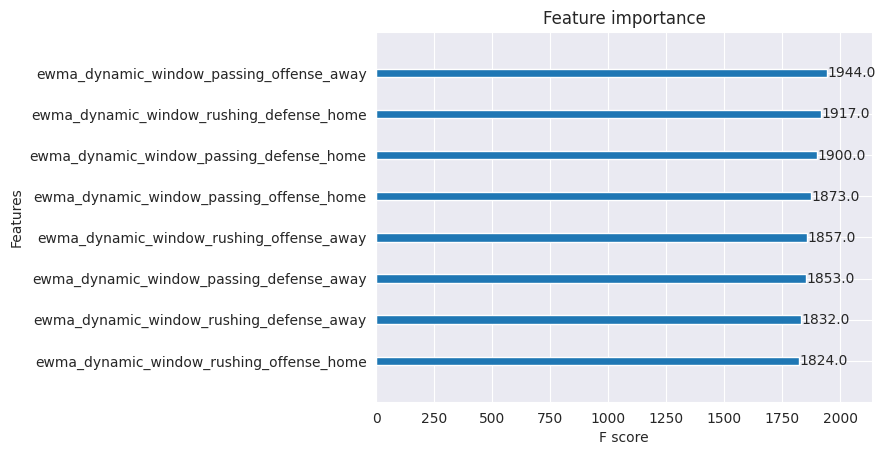

In [56]:
params = {
    'booster': 'gbtree',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'tree_method': 'approx',
    'sampling_method': 'gradient_based',
    'eval_metric': 'logloss',
    'eta': 0.2453,
    'gamma': 17.01,
    'subsample': 0.2824,
    'max_depth': 14,
    'min_child_weight': 25.26
}

optimized_params = bayes_opt.max['params']
optimized_params['max_depth'] = int(optimized_params['max_depth'])
params.update(optimized_params)

model = xgb.train(params=params, dtrain=train_data, num_boost_round=num_rounds, verbose_eval=2)
model.save_model('ewma_model_xgboost_stratified_k_fold.json')

feature_importance = model.get_score(importance_type='weight')
xgb.plot_importance(feature_importance)

In [57]:
test_data.reset_index(drop=True, inplace=True)
test_matrix = xgb.DMatrix(data=test_data, nthread=-1)
test_df = schedule.loc[schedule["season"] >= 2023]
test_df.reset_index(drop=True, inplace=True)
logloss_score, accuracy, preds = get_scores(test_matrix, test_df, model)

print(f"Log Loss: {logloss_score}")
print(f"Accuracy: {accuracy}")

Log Loss: 0.6647950527421282
Accuracy: 0.6510791366906474


### EWMA Model - XGBoost with GroupKFold Cross Validation

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

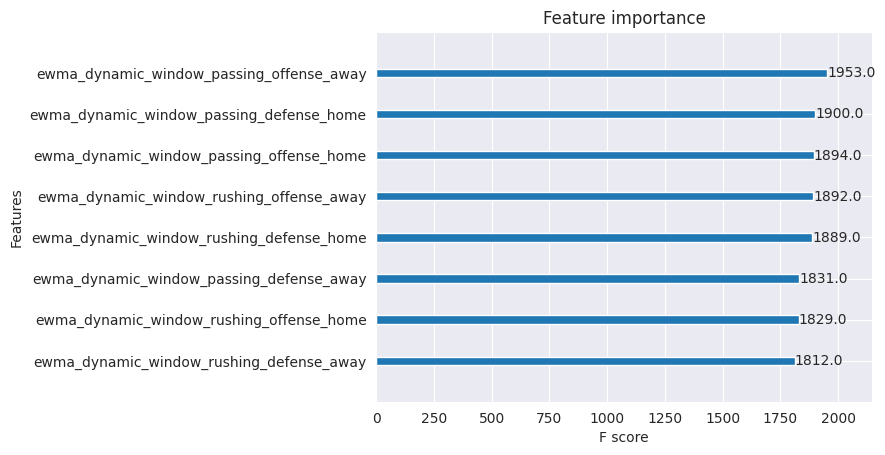

Log Loss: 0.664905401747483
Accuracy: 0.644927536231884


In [20]:
preds.head()

,wp,season,week,home_team,away_team,home_score,away_score,home_team_win
0,0.714393,2023,1,WAS,ARI,20,16,1
1,0.500882,2023,1,NYJ,BUF,22,16,1
2,0.522753,2023,1,ATL,CAR,24,10,1
3,0.504583,2023,1,CLE,CIN,24,3,1
4,0.356635,2023,1,NYG,DAL,0,40,0


RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

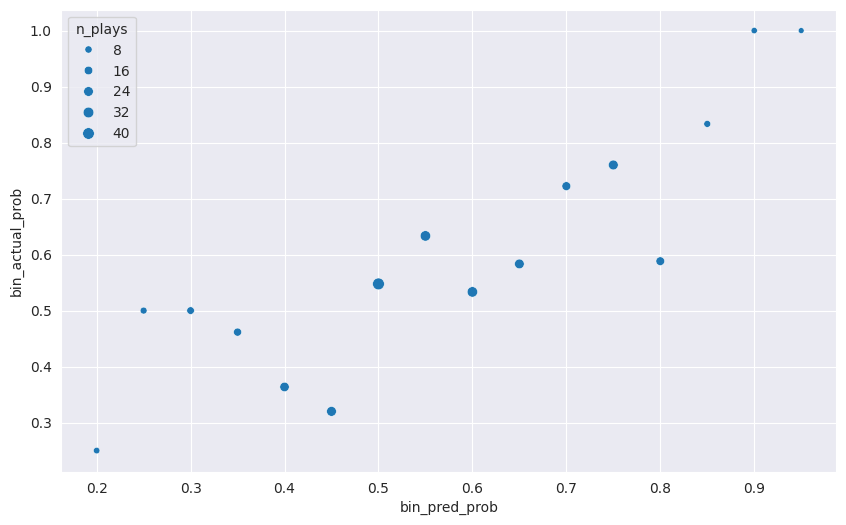

In [39]:
np.random.seed(420)

plot_calibration_score(preds)

In [40]:
preseason_games = pd.DataFrame({
    'home_team': ['BUF', 'TB'],
    'away_team': ['PIT', 'PHI'],
    'home_score': [0, 0],
    'away_score': [0, 0],
    'home_spread_line': [-10, 3]})
pregame_predictions = get_pregame_predictions(pbp_data, 2023, model, preseason_games)
pregame_predictions

,home_team,away_team,home_score,away_score,home_spread_line,home_win_prob,final_score_diff,recommended_bet,final_spread,correct_prediction
0,BUF,PIT,0,0,-10,0.743589,0,BUF,-10,0
1,TB,PHI,0,0,3,0.706802,0,PHI,3,0


In [27]:
accuracy = pregame_predictions.loc[pregame_predictions['winner'] != 'NONE', 'correct_prediction'].mean()
print(f"Accuracy: {round(accuracy * 100, 2)}%")

KeyError: 'winner'

In [ ]:
pregame_predictions['stake'] = 10
pregame_predictions['to_win'] = np.where(
    (pregame_predictions['home_spread_line'] > 0), pregame_predictions["stake"] * 2, pregame_predictions["stake"] * 0.9)
pregame_predictions['wager_result'] = np.where(
    (pregame_predictions['correct_prediction'] == 1), pregame_predictions["to_win"], 0)
total_wagers = pregame_predictions['stake'].sum()
returns = pregame_predictions['wager_result'].sum()
print(f"Total Wagered: {total_wagers}; Total Won: {returns}")

In [29]:
df_2022 = predict_season(schedule, 2023, clf, features)
df_2022.head(30)

/home/dev/.virtualenvs/nfl-data-models/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/dev/.virtualenvs/nfl-data-models/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
0,KC,CHI,3,KC,KC,0.866892,1
1,BUF,NYG,6,BUF,BUF,0.857427,1
2,ARI,SF,15,SF,SF,0.835222,1
3,SF,SEA,14,SF,SF,0.824217,1
4,DAL,NYG,10,DAL,DAL,0.809007,1
5,MIA,NYG,5,MIA,MIA,0.807483,1
6,PHI,WAS,4,PHI,PHI,0.805282,1
7,HOU,ARI,11,HOU,HOU,0.804385,1
8,NYJ,KC,4,KC,KC,0.803821,1
9,MIA,NYJ,15,MIA,MIA,0.802500,1


In [30]:
results = get_correct_predictions(df_2022)
results

week
1     0.500000
2     0.500000
3     0.750000
4     0.625000
5     0.428571
6     0.733333
7     0.153846
8     0.562500
9     0.785714
10    0.642857
11    0.714286
12    0.562500
13    0.692308
14    0.466667
15    0.625000
16    0.562500
17    0.750000
18    0.625000
19    0.750000
Name: correct_prediction, dtype: float64

In [31]:
get_season_prediction_outcomes(df_2022, results)

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
39,NO,CHI,9,NO,NO,0.741799,1
79,CLE,ARI,9,CLE,CLE,0.674901,1
83,BAL,SEA,9,BAL,BAL,0.663450,1
100,HOU,TB,9,HOU,HOU,0.647980,1
144,PHI,DAL,9,PHI,PHI,0.598379,1
164,CIN,BUF,9,BUF,CIN,0.579845,0
185,PIT,TEN,9,PIT,PIT,0.566519,1
193,NYJ,LAC,9,LAC,LAC,0.562027,1
196,LV,NYG,9,LV,LV,0.559509,1
206,KC,MIA,9,KC,KC,0.554409,1
